# Music Genre Classification

This notebook contains implementations of Convolutional Neural Networks for the purpose of music genre classification. The first part is a simplified approach with a Feedforward Network that is using Mel-frequency cepstrums (MFCC). In the second part are Convolutional Networks of increased complexity and features that are using Mel-spectograms. In the final part of the notebook the best model is used to classify unseen data by converting audio from youtube music clips to melgrams and then making predictions.

## Approach 1: Feedforward Neural Network

### Step 1: Loading the Data (mfccs)

-  Initially importing necessary libraries.

In [119]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import seaborn
import torch
from torchmetrics.functional import f1_score
import random
import matplotlib.pyplot as plt
import librosa
import librosa.display
import math
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim
import time
import datetime
import os
import sys
import torch.optim.lr_scheduler as lr_scheduler
import youtube_dl
import re

- Then loading the train, validation and test data.

In [3]:

# Training Data
X_train = np.load("music_genre_data_di/train/mfccs/X.npy")
labels_train = np.load("music_genre_data_di/train/mfccs/labels.npy")

# Validation Data
X_val = np.load("music_genre_data_di/val/mfccs/X.npy")
labels_val = np.load("music_genre_data_di/val/mfccs/labels.npy")

# Testing Data
X_test = np.load("music_genre_data_di/test/mfccs/X.npy")
labels_test = np.load("music_genre_data_di/test/mfccs/labels.npy")

In [4]:
# Then the labels mapping
labelsMapping, indexed_labels_train = np.unique(labels_train, return_inverse=True)
labelsMapping, indexed_labels_val = np.unique(labels_val, return_inverse=True)
labelsMapping, indexed_labels_test = np.unique(labels_test, return_inverse=True)

In [3]:
# Dataset class
class customDataset(Dataset):

    def __init__(self, xdata, ydata):
        self.x = torch.from_numpy(xdata)
        self.y = torch.from_numpy(ydata)
        self.samples = ydata.shape[0]

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [6]:
# Datasets
trainDataset = customDataset(X_train, indexed_labels_train)
valDataset = customDataset(X_val, indexed_labels_val)
testDataset = customDataset(X_test, indexed_labels_test)

# Corresponding Dataloaders
train_dataloader = DataLoader(dataset=trainDataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset=valDataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset=testDataset, batch_size=16, shuffle=False)

### Step 2: Defining the Neural Network 

- Then I define the Fully Connected Neural Network with a linear stack and without activation functions.

In [9]:
# Fully Connected Neural Network
class fcNeuralNetwork(nn.Module):
    
    def __init__(self):
        super(fcNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(26, 128), 
            nn.Linear(128, 32), 
            nn.Linear(32, 4),
        )

    def forward(self, x): 
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

### Step 3. Defining Training Functions

- The trainEpoch function predicts and calculates the loss for each batch of an epoch, then informs the weights and continues. At the end it returns the mean loss.
- The trainNetwork function simply trains the model for the specified number of epochs.

In [4]:
# Train the neural network for one epoch
def trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display=True):

    losses = []

    # For each batch
    for batch, (x, y) in enumerate(dataloader):

        x = x.float()

        # In case the device was set
        x = x.to(device)
        y = y.to(device)
        
        # Predict and calculate loss
        prediction = neuralnetwork(x)
        loss = lossfunc(prediction, y)
        losses.append(loss.item())

        # Inform weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printing every mod 64
        if(display):
            if batch % 64 == 0:
                size = len(dataloader.dataset)
                loss, current = loss.item(), batch * len(x)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # Return mean loss
    meanloss = sum(losses)/len(losses)
    return meanloss
 
# Train the network for specific epochs
def trainNetwork(epochs, optimizer, dataloader, lossfunc, neuralnetwork, device, display=True):

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display)
        if (display):
            print("_________________________________")
        
    # Return the model
    return neuralnetwork

### Step 4: Defining the Evaluation Function

- The evaluationFunction makes predictions without informing the weights and returns the loss, accuracy as well as the F1-macro averaged score ie: $F1_{macro} = \frac{1}{N} \sum_{i=0}^N F1_i $

In [5]:
# Evaluation function
def evaluationFunction(dataloader, model, lossfunc, device, display=True):

    # Variable initialisation
    correctCount = 0
    sampleCount = 0
    losses = []
    preds = []
    trues = []

    # Set the model to eval mode
    model.eval()
    with torch.no_grad():
        
        for (x,y) in dataloader:
            x = x.float()
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            loss = lossfunc(scores, y).item()
            losses.append(loss)

            # Save the predictions to be used for the metrics
            predictions= torch.abs(predictions.cpu())
            y=y.cpu()
            preds.extend(predictions.numpy())
            trues.extend(y.numpy())
            correctCount += (predictions==y).sum()
            sampleCount += predictions.size(0)
    
    # Metric calculation
    f1macro = f1_score(preds=torch.tensor(preds), target=torch.tensor(trues), average="macro", num_classes=4).item() * 100
    accuracy = float(correctCount) / float(sampleCount) * 100
    meanloss = sum(losses)/len(losses)

    # If display is set to true print the results
    if display:
        print("\nEvaluation Results")
        print("_________________________________")
        print(
            f"Predicted {correctCount} / {sampleCount} correctly"
            f"\nMean Loss: {meanloss:.2f} "
            f"\nAccuracy: {accuracy:.2f}%"
            f"\nMacro Averaged F1-score: {f1macro:.2f}%"
            )
        print("_________________________________")

    # Re-set to train mode
    model.train()

    return trues, preds, meanloss, accuracy, f1macro

In [6]:
# Confusion Matrix Plotting
def confusionMatrix(trues, preds):
    names =[labelsMapping[0], labelsMapping[1], labelsMapping[2],labelsMapping[3]]
    cfmatr = confusion_matrix(trues, preds)
    df_cm = pd.DataFrame(cfmatr/np.sum(cfmatr) * 4, index = [i for i in names],
                     columns = [i for i in names])
    plt.figure(figsize = (9,9))
    seaborn.heatmap(df_cm, cmap='viridis_r', annot=True)
    plt.show()

### Step 5: Training

Then, I train this naive neural network on the train set and evaluate on the test set using:
- Optimizer: stochastic gradient descent
- Learning rate: 0.002
- Loss function: Cross-entropy loss
- Epochs: 30


Epoch 1
_________________________________
loss: 1.454725  [    0/ 3200]
loss: 1.417103  [ 1024/ 3200]
loss: 1.339165  [ 2048/ 3200]
loss: 1.347571  [ 3072/ 3200]
_________________________________

Epoch 2
_________________________________
loss: 1.348407  [    0/ 3200]
loss: 1.401512  [ 1024/ 3200]
loss: 1.344160  [ 2048/ 3200]
loss: 1.293520  [ 3072/ 3200]
_________________________________

Epoch 3
_________________________________
loss: 1.361470  [    0/ 3200]
loss: 1.260832  [ 1024/ 3200]
loss: 1.313265  [ 2048/ 3200]
loss: 1.357408  [ 3072/ 3200]
_________________________________

Epoch 4
_________________________________
loss: 1.337888  [    0/ 3200]
loss: 1.346400  [ 1024/ 3200]
loss: 1.247607  [ 2048/ 3200]
loss: 1.292044  [ 3072/ 3200]
_________________________________

Epoch 5
_________________________________
loss: 1.354656  [    0/ 3200]
loss: 1.311459  [ 1024/ 3200]
loss: 1.359026  [ 2048/ 3200]
loss: 1.213249  [ 3072/ 3200]
_________________________________

Epoch 6
______

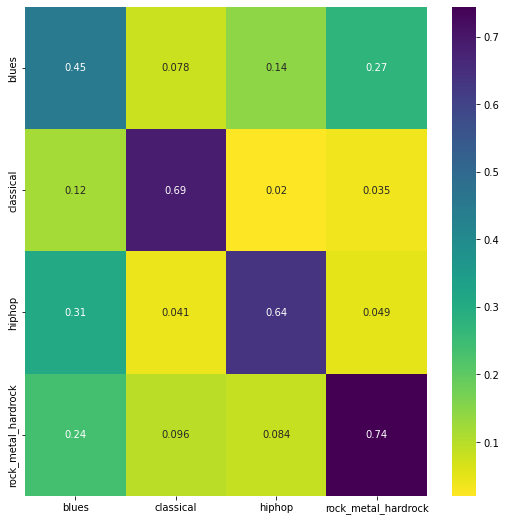

In [22]:
# To compare later the CPU with the GPU time
startTime = time.time()

# Hyperparameters
epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader
model = fcNeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()
device = 'cpu'

# Network training
model = trainNetwork(epochs, optimizer, dataloader, lossfunc, model, device)

# Evaluate on the test set and print the confusion matrix
trues, preds, meanloss, acura, f1 = evaluationFunction(test_dataloader, model, lossfunc, device)
confusionMatrix(trues, preds)

# Keeping the CPU time
endTime = time.time()
CPUtime = endTime - startTime

- After 30 epochs the accuracy and F1-score are around 63% and looking at the confusion matrix the model classified rock and classical music better than the other two genres.

### Step 6: Train on the GPU

- Here, specifying the GPU to be the device that the operations of the neutal network are performed in. Running the notebook locally I used the metal framework and online it falls back to cuda.

In [24]:
# MPS for apple silicon, otherwise fall back to cuda
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda'
startTime = time.time()

# Hyperparameters
epochs= 30
learning_rate = 2e-3

# Use the GPU explicitly (no fall back to CPU to compare the times)
model = fcNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()

# Train the network with display set to false this time
trainNetwork(epochs, optimizer, train_dataloader, lossfunc, model, device, display=False)

# Evaluate on the test set
evaluationFunction(test_dataloader, model, lossfunc, device)

endTime = time.time()
GPUtime = endTime - startTime

# Compare the times
print("CPU time: ", CPUtime)
print("GPU time: ", GPUtime)


Evaluation Results
_________________________________
Predicted 869 / 1376 correctly
Mean Loss: 0.95 
Accuracy: 63.15%
Macro Averaged F1-score: 62.32%
_________________________________
CPU time:  3.4686331748962402
GPU time:  38.30944204330444


- The accuracy and F1-score are similar as expected. Comparing the times it is apparent that there is no benefit from using the GPU here and it is actually 10 times slower. This is of course since a simple feedforward network with a small number of data will be faster on the faster CPU cores. On the convolutional neural networks that follow they take advantage of the parallelisation on the large data and it is much faster.

### Step 7: Best snapshot of the Network

- To find the best snapshot of the model during training I train again for 30 epochs, but use the validation set as "control" and save the model at the specific epoch that it has the best performance on the F1-Score metric so far. Then I use this model to evaluate on the test set.

Epoch 1

Evaluation Results
_________________________________
Predicted 201 / 800 correctly
Mean Loss: 1.38 
Accuracy: 25.12%
Macro Averaged F1-score: 10.29%
_________________________________
Epoch 2

Evaluation Results
_________________________________
Predicted 269 / 800 correctly
Mean Loss: 1.34 
Accuracy: 33.62%
Macro Averaged F1-score: 21.39%
_________________________________
Epoch 3

Evaluation Results
_________________________________
Predicted 295 / 800 correctly
Mean Loss: 1.32 
Accuracy: 36.88%
Macro Averaged F1-score: 29.70%
_________________________________
Epoch 4

Evaluation Results
_________________________________
Predicted 316 / 800 correctly
Mean Loss: 1.31 
Accuracy: 39.50%
Macro Averaged F1-score: 32.37%
_________________________________
Epoch 5

Evaluation Results
_________________________________
Predicted 427 / 800 correctly
Mean Loss: 1.26 
Accuracy: 53.37%
Macro Averaged F1-score: 48.08%
_________________________________
Epoch 6

Evaluation Results
____________

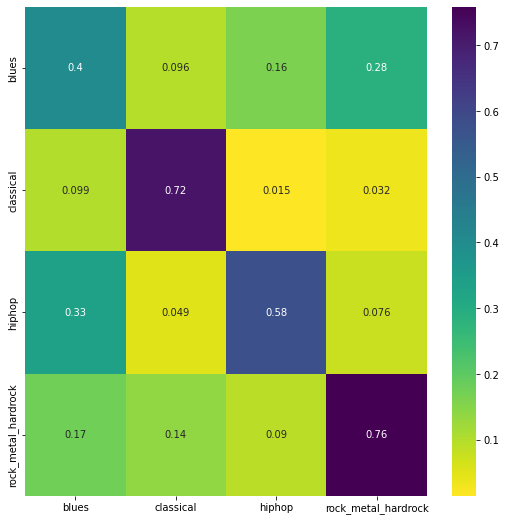

In [29]:
# Hyperparameters
epochs= 30
learning_rate = 2e-3
device = 'cpu'
model = fcNeuralNetwork().to(device)
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
bestf1=0
bestepoch=0

# For each epoch
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")

    # Training
    meanLoss = trainEpoch(optimizer, train_dataloader, lossfunc,  model, device, False)

    # Evaluate on the validation set
    _, _, meanloss, _, macrof1 = evaluationFunction(val_dataloader, model, lossfunc, device, True)

    # If it performed better
    if (bestf1<macrof1):
        bestepoch=epoch
        bestf1=macrof1

        # Save the best model and optimizer
        torch.save(model.state_dict(), './bestFCmodel.pt')
        torch.save(optimizer.state_dict(), './bestFCoptimizer.pt')

print("\nBest F1 macro average score: ", macrof1," achieved after ", bestepoch, " epochs.")

# Initialise and load the best model
model = fcNeuralNetwork()
model.load_state_dict(torch.load('./bestFCmodel.pt'))
model = model.to(device)

# Evaluate on the test set
trues, preds, meanloss, acura, f1 = evaluationFunction(test_dataloader, model, lossfunc, device, display=True)
confusionMatrix(trues, preds)

- The accuracy and F1-Score are around 60% again, so there is no improvement, but that is achieved after 25 epochs. This shows that the model stops to learn after that and maybe shows signs of over fitting too. So this makes it clear that early stopping would be wise to be used later on.

## Approach 2: Convolutional Neural Network

### Step 1: Loading the Data (Mel-Spectrograms)

- Initially, defining the Dataset class for the mel-spectograms.

In [ ]:
# Dataset class
class customMelDataset(Dataset):

    def __init__(self, xdata, ydata):
        xdata = xdata[:, np.newaxis, :, :]
        self.x = torch.from_numpy(xdata)
        self.y = torch.from_numpy(ydata)
        self.samples = ydata.shape[0]

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

- Then, loading the data as before, but with the melgram data this time.

In [8]:
# Training Data
Mel_train = np.load("music_genre_data_di/train/melgrams/X.npy")
labels_train_mel = np.load("music_genre_data_di/train/melgrams/labels.npy")

# Validation Data
Mel_val = np.load("music_genre_data_di/val/melgrams/X.npy")
labels_val_mel = np.load("music_genre_data_di/val/melgrams/labels.npy")

# Testing Data
Mel_test = np.load("music_genre_data_di/test/melgrams/X.npy")
labels_test_mel = np.load("music_genre_data_di/test/melgrams/labels.npy")

# The mapping labels sorted
labelsMapping, indexed_labels_train_mel = np.unique(labels_train_mel, return_inverse=True)
labelsMapping, indexed_labels_val_mel = np.unique(labels_val_mel, return_inverse=True)
labelsMapping, indexed_labels_test_mel = np.unique(labels_test_mel, return_inverse=True)

# Datasets for the melgrams
trainMelDataset = customMelDataset(Mel_train, indexed_labels_train_mel)
valMelDataset = customMelDataset(Mel_val, indexed_labels_val_mel)
testMelDataset = customMelDataset(Mel_test, indexed_labels_test_mel)

# Corresponding dataloaders
train_Mel_dataloader = DataLoader(dataset=trainMelDataset, batch_size=16, shuffle=True)
val_Mel_dataloader = DataLoader(dataset=valMelDataset, batch_size=16, shuffle=True)
test_Mel_dataloader = DataLoader(dataset=testMelDataset, batch_size=16, shuffle=False)

- Visualising a random melgram from each set. The mel-spectograms are a 21 (time) by 128 (frequency) matrix and I plot them transposed using the librosa library.

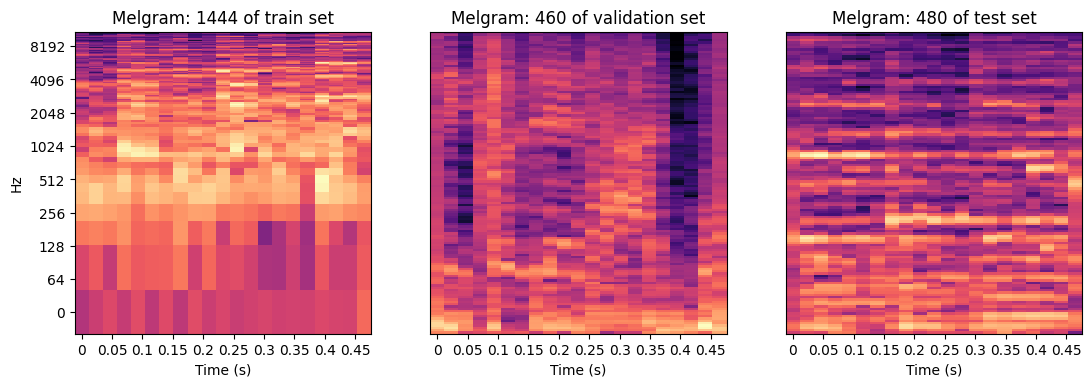

In [45]:
# A random melgram from each class
i = random.randint(0,Mel_train.shape[0]-1)
j = random.randint(0,Mel_val.shape[0]-1)
k = random.randint(0,Mel_test.shape[0]-1)
y = Mel_train[i].T
x = Mel_val[j].T
z = Mel_test[k].T

# Plotting
plt.figure(figsize=(13, 4), dpi=100)
plt.subplot(131)
plt.title(f'Melgram: {i} of train set');
librosa.display.specshow(y, x_axis='s', y_axis='log')
plt.subplot(132)
plt.title(f'Melgram: {j} of validation set');
librosa.display.specshow(x, x_axis='s')
plt.subplot(133)
plt.title(f'Melgram: {k} of test set');
librosa.display.specshow(z, x_axis='s')
plt.show()

### Step 2: Vanilla Convolutional Neural Network

In each subsequent step more features will be added to the convolutional neural network, but the first will be a naive implementation comprised of:

- 4 convolutional layers, of kernel size 5 and input channels: 1, 16, 32, 64, 128.

- A fully connected stack of 5 layers.

To calculate the output dimension of the convolutional layer with kernel K, stride S και padding P:

- $H_{out} = \frac{H_{in}-K+2P}{S} +1 $
- $W_{out} = \frac{W_{in}-K+2P}{S} +1 $

Since, padding size is 0, Kernel size is 5 and stride is 1 these simplify to:

- $H_{out} = H_{in}-4 $
- $W_{out} = W_{in}-4 $

Since $H_{in}=21$ and $W_{in}=128$ after four layers:

- $H_{out} = H_{in}-4\times 4 = 21-16=5$
- $W_{out} = W_{in}-4\times 4 = 128-16=112$

So the final dimension after flatten would be: $5 \times 112 \times 128 = 71680$

In [9]:
# Convolutional Neural Network
class firstConvolutionalNeuralNetwork(nn.Module):
    
    def __init__(self):
        super(firstConvolutionalNeuralNetwork, self).__init__()

        # First convolutional layer taking 1 input channel, outputting 16 convolutional features
        self.conv1 = nn.Conv2d(1, 16, 5)

        # Second convolutional layer, taking 16 input layers, outputting 32 convolutional features
        self.conv2 = nn.Conv2d(16, 32, 5)

        # Second convolutional layer, taking 32 input layers, outputting 64 convolutional features
        self.conv3 = nn.Conv2d(32, 64, 5)

        # Second convolutional layer, taking 64 input layers, outputting 128 convolutional features
        self.conv4 = nn.Conv2d(64, 128, 5)

        self.flatten = nn.Flatten()

        # Fully connected stack
        self.connected_stack = nn.Sequential(
            nn.Linear(71680, 1024), 
            nn.Linear(1024, 256), 
            nn.Linear(256, 32),
            nn.Linear(32, 4),
        )

    def forward(self, x): 
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.connected_stack(x)
        return logits

### Step 3: Training

Before, training I define the optimalModel function to automate finding the optimal snapshot of the model.

In [10]:
# Function that finds the best snapshot of the model
def optimalModel(device, model, epochs, traindataloader, valdataloader, optimizer, lossfunc, display=False, scheduler=None):

    bestf1=0
    bestepoch=0
    
    # For each epoch
    for epoch in range(epochs):

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        
        # Training
        trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display)

        # Evaluation
        _, _, meanloss, _, macrof1 = evaluationFunction(valdataloader, model, lossfunc, device, display)
        
        # If the score is better
        if (bestf1<macrof1):
            bestepoch=epoch
            bestf1=macrof1

            # Save the model
            torch.save(model.state_dict(), './bestCNNmodel.pt')
            torch.save(optimizer.state_dict(), './bestCNNoptimizer.pt')
            if(scheduler):
                torch.save(scheduler.state_dict(), './bestCNNscheduler.pt')
    
        if(display):
            print("__________________________________")
        
        # If a scheduler was set here perform the step
        if (scheduler):
            if (scheduler.__class__.__name__=='ReduceLROnPlateau'):
                scheduler.step(meanloss)
            else:
                scheduler.step()

    return bestepoch

- Then train the model using this function and evaluate on the test set.

Epoch 1
__________________________________
loss: 1.404003  [    0/ 3200]
loss:     nan  [ 1024/ 3200]
loss:     nan  [ 2048/ 3200]
loss:     nan  [ 3072/ 3200]

Evaluation Results
_________________________________
Predicted 200 / 800 correctly
Mean Loss: nan 
Accuracy: 25.00%
Macro Averaged F1-score: 10.00%
_________________________________
__________________________________
Epoch 2
__________________________________
loss:     nan  [    0/ 3200]
loss:     nan  [ 1024/ 3200]
loss:     nan  [ 2048/ 3200]
loss:     nan  [ 3072/ 3200]

Evaluation Results
_________________________________
Predicted 200 / 800 correctly
Mean Loss: nan 
Accuracy: 25.00%
Macro Averaged F1-score: 10.00%
_________________________________
__________________________________
Epoch 3
__________________________________
loss:     nan  [    0/ 3200]
loss:     nan  [ 1024/ 3200]
loss:     nan  [ 2048/ 3200]
loss:     nan  [ 3072/ 3200]

Evaluation Results
_________________________________
Predicted 200 / 800 correctly
Me

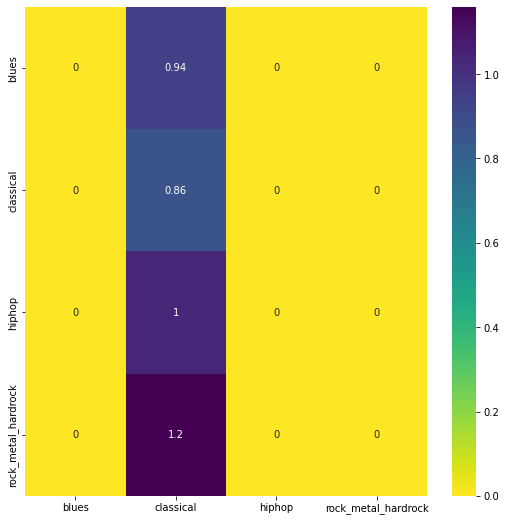

In [17]:
# Hyperparameters and Network initialisation
learning_rate = 2e-3
epochs= 30
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda'
model = firstConvolutionalNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()

# Train the model and find optimal model
bestepoch = optimalModel(device, model, epochs, train_Mel_dataloader, val_Mel_dataloader, optimizer, lossfunc, True)
print("\nBest F1 macro average score achieved after ", bestepoch, " epochs.")

# Load the best model
model = firstConvolutionalNeuralNetwork().to(device)
model.load_state_dict(torch.load('./bestCNNmodel.pt'))
model = model.to(device)

# Evaluate on the test set
trues, preds, meanloss, acura, f1 = evaluationFunction(test_Mel_dataloader, model, lossfunc, device, True)
confusionMatrix(trues, preds)

- From the results it is clear that the model is unable to train. The loss immediately goes to infinity so it means that the principal features cannot be extracted. This highlights the importance of Max pooling.

### Step 4: Pooling and Padding

In this step I will introduce to the Convolutional Neural Network Max Pooling layers of kernel size 2 and padding 2. To calculate the dimension of the last convolutional layer the equations are:

- $H_{out} = \frac{H_{in}-5+2 \times 2}{1} +1 = H_{in}-1 +1= H_{in} $
- $W_{out} =\frac{W_{in}-5+2 \times 2}{1} +1 =  W_{in}- 1+1 = W_{in} $

So, the dimensions remain the same. Then passing these from the max pool layer:

- $H_{out} = floor ( \frac{H_{in}-2}{2} +1 ) $
- $W_{out} =floor (\frac{W_{in}-2}{2} +1 ) $

Since $H_{in}=21$ and $W_{in}=128$ after four convolutional layers:

- $H_{out1} = floor ( \frac{21-2}{2} +1 ) = 10$
- $H_{out2} = floor ( \frac{10-2}{2} +1 ) = 5$
- $H_{out3} = floor ( \frac{5-2}{2} +1 ) =  2$
- $H_{out4} = floor ( \frac{2-2}{2} +1 ) =  1$
- $W_{out1} =floor (\frac{128-2}{2} +1 ) =64$
- $W_{out2} =floor (\frac{64-2}{2} +1 ) =32$
- $W_{out3} =floor (\frac{32-2}{2} +1 ) =16$
- $W_{out4} =floor (\frac{16-2}{2} +1 ) =8$

So the final dimension after flatten will be: $1 \times 8 \times 128 = 1024$

In [11]:

# Convolutional Neural Network with max pooling
class secondConvolutionalNeuralNetwork(nn.Module):
    
    def __init__(self):
        super(secondConvolutionalNeuralNetwork, self).__init__()

        # First convolutional layer taking 1 input channel, outputting 16 convolutional features
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)

        # Second convolutional layer, taking 16 input layers, outputting 32 convolutional features
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)

        # Second convolutional layer, taking 32 input layers, outputting 64 convolutional features
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)

        # Second convolutional layer, taking 64 input layers, outputting 128 convolutional features
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)

        self.flatten = nn.Flatten()
        self.connected_stack = nn.Sequential(
            nn.Linear(1024, 1024), 
            nn.Linear(1024, 256), 
            nn.Linear(256, 32),
            nn.Linear(32, 4),
        )

    def forward(self, x): 

        x = F.max_pool2d(self.conv1(x), kernel_size=2)
        x = F.max_pool2d(self.conv2(x), kernel_size=2)
        x = F.max_pool2d(self.conv3(x), kernel_size=2)
        x = F.max_pool2d(self.conv4(x), kernel_size=2)
        x = self.flatten(x)

        logits = self.connected_stack(x)
        return logits

Epoch 1
__________________________________
loss: 1.383597  [    0/ 3200]
loss: 1.470263  [ 1024/ 3200]
loss: 1.263352  [ 2048/ 3200]
loss: 1.146643  [ 3072/ 3200]

Evaluation Results
_________________________________
Predicted 370 / 800 correctly
Mean Loss: 1.22 
Accuracy: 46.25%
Macro Averaged F1-score: 32.03%
_________________________________
__________________________________
Epoch 2
__________________________________
loss: 1.211574  [    0/ 3200]
loss: 1.041963  [ 1024/ 3200]
loss: 1.135424  [ 2048/ 3200]
loss: 1.114866  [ 3072/ 3200]

Evaluation Results
_________________________________
Predicted 432 / 800 correctly
Mean Loss: 1.04 
Accuracy: 54.00%
Macro Averaged F1-score: 51.89%
_________________________________
__________________________________
Epoch 3
__________________________________
loss: 1.024523  [    0/ 3200]
loss: 1.203246  [ 1024/ 3200]
loss: 1.075132  [ 2048/ 3200]
loss: 1.230510  [ 3072/ 3200]

Evaluation Results
_________________________________
Predicted 388 / 800

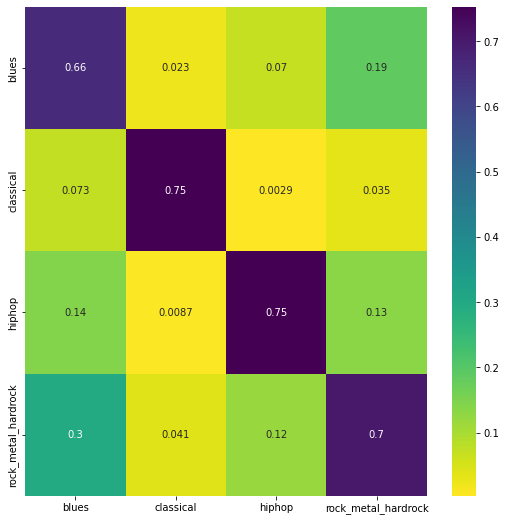

In [18]:
# Hyperparameters and network initialisation
learning_rate = 2e-3
epochs= 30
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda'
model = secondConvolutionalNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()

# Network training
bestepoch = optimalModel(device, model, epochs, train_Mel_dataloader, val_Mel_dataloader, optimizer, lossfunc, True)
print("\nBest F1 macro average score achieved after ", bestepoch, " epochs.")

# Load the best model
model = secondConvolutionalNeuralNetwork().to(device)
model.load_state_dict(torch.load('./bestCNNmodel.pt'))
model = model.to(device)

# Evaluate on the test set
trues, preds, meanloss, acura, f1 = evaluationFunction(test_Mel_dataloader, model, lossfunc, device, True)
confusionMatrix(trues, preds)

- The Convolutional Network now is able to learn and performs adequately in classifying the genres with 71% accuracy. The reduction of dimensions makes the model much faster, as the training finished ten times sooner than before. The best snapshot of the model is found after 23 epochs and from the loss it is clear that after this point it remains stable.

- Max Pooling selects the element with the maximum value from each kernel, keeping this way the most important features. It also adds position invariance on the model, since the location of this element isn't significant, but its presence. Padding is important, so that the dimensions remain the same between input and output layers, but also so that the values on the "margins" of the matrix are taken into account.

### Step 5: Optimizer Algorithms

- PyTorch provides a range of optimization algorithms to update the parameters of a model during training. Each optimizer has its own unique strengths and weaknesses, therefore, comparing their performance is important to determine the one that is most effective at reducing the loss function and improving the accuracy of the model.

In [23]:
# Hyperparameters
learning_rate = 2e-3
epochs= 30
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda'
lossfunc = nn.CrossEntropyLoss()

# Optimizers
optimizers = [    
                torch.optim.Adadelta
                , torch.optim.Adagrad
                , torch.optim.Adam
                , torch.optim.Adamax
                , torch.optim.ASGD
                , torch.optim.SGD
            ]

# Matrix to keep the results
Results = np.empty(shape=(4, 7), dtype=object)
Results[0,0] = ""
Results[1,0] = "Accuracy"
Results[2,0] = "F1-score"
Results[3,0] = "Time"

# For each optimizer
for i, optimizer in enumerate(optimizers):
    print("Testing with optimizer algorithm: ", optimizer.__name__)
    Results[0,i+1] = optimizer.__name__
    startTime = time.time()

    model = secondConvolutionalNeuralNetwork().to(device)
    opti = optimizer(model.parameters(), lr = learning_rate)

    # Train the network and find optimal model
    bestepoch = optimalModel(device, model, epochs, train_Mel_dataloader, val_Mel_dataloader, opti, lossfunc, False)
    print("\nBest F1 macro average score achieved after ", bestepoch, " epochs.")

    # Load the best model
    model = secondConvolutionalNeuralNetwork().to(device)
    model.load_state_dict(torch.load('./bestCNNmodel.pt'))
    model = model.to(device)

    # Evaluate on the test set
    trues, preds, meanloss, acura, f1 = evaluationFunction(test_Mel_dataloader, model, lossfunc, device, True)

    endTime = time.time()
    took = endTime - startTime
    Results[1,i+1] = float("{:.2f}".format(acura))
    Results[2,i+1] = float("{:.2f}".format(f1))
    Results[3,i+1] = str(datetime.timedelta(seconds=took))

with pd.option_context('expand_frame_repr', False):
    print(DataFrame(Results))

Testing with optimizer algorithm:  Adadelta

Best F1 macro average score achieved after  29  epochs.

Evaluation Results
_________________________________
Predicted 951 / 1376 correctly
Mean Loss: 0.76 
Accuracy: 69.11%
Macro Averaged F1-score: 69.62%
_________________________________
Testing with optimizer algorithm:  Adagrad

Best F1 macro average score achieved after  29  epochs.

Evaluation Results
_________________________________
Predicted 1054 / 1376 correctly
Mean Loss: 1.24 
Accuracy: 76.60%
Macro Averaged F1-score: 77.05%
_________________________________
Testing with optimizer algorithm:  Adam

Best F1 macro average score achieved after  6  epochs.

Evaluation Results
_________________________________
Predicted 959 / 1376 correctly
Mean Loss: 1.06 
Accuracy: 69.69%
Macro Averaged F1-score: 70.96%
_________________________________
Testing with optimizer algorithm:  Adamax

Best F1 macro average score achieved after  3  epochs.

Evaluation Results
_____________________________

- From the performance of the model on the test set the `Adagrad` optimizer has the best accuracy and F1-score.

|    |             Adadelta  |       Adagrad       |     Adam |         Adamax    |        ASGD    |         SGD |
| ----------- | ----------- |----------- |----------- |----------- |----------- |----------- |
| Accuracy       |    69.11   |         76.6   |        69.69   |        74.64  |         73.47         |   70.2|
| F1-score       |    69.62  |         77.05  |         70.96  |         74.69  |         74.24         |  70.82|
|     Time | 0:03:59.492682 | 0:02:29.794995 | 0:06:10.385762 | 0:05:42.255715 | 0:02:48.876544 | 0:02:30.302194|

- `Adam` and `Adamax` are the slower in training time, but looking at the best snapshot of the model that is 6 and 3 epochs respectively it is clear that they stop improving after this point. `Adam`, of course, is using the exponentially weighted average of the gradients, which makes it reach the minimum much faster. The rest of the optimizers have similar behaviour and they need more epochs to find the minimum.

- `Adagrad` has the best performance across the metrics, as it adjusts the learning rate according to the frequency of the feature. `Adadelta` being an improvement of `Adagrad` having a "memory" of the previous best gradients doesn't have a better performance, but this also could be because of the initial values of the weights or that more epochs are required.

- `Stochastic Gradient Descent` is marginally worse than `Averaged Stochastic Gradient Descent`, while `ASGD` reached over 70% accuracy in much less epochs. This might be because it uses an average of the weights, which might reduce the effect of the noise. Their performance though is similar and in terms of an optimizer like `SGD` the big oscillations could be eliminated by selecting a better initial learning rate and with the use of a scheduler.

## Improving Performance

### Step 1: Reproducibility

- Firstly, I define a function for seeding, so that the initial parameters are the same for each run of the training process. This makes it possible to reproduce the training process and compare the performance of different models with confidence. It also helps to avoid issues such as overfitting, where the model becomes too closely fit to the training data and performs poorly on new data.

In [1]:
# Seeding function
def seedTorch(seed=33):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

### Step 2: Activation Functions

- Non-linear activation functions help the network capture more complex patterns in the data, enabling it to learn sophisticated representations. Additionally, they help prevent the vanishing gradient problem, which can occur when gradients become very small, making it difficult for the network to learn and update the weights. To experiment with different activation functions I will add this on the class as a parameter on its constructor.

In [21]:
# Convolutional Neural Network with activation functions
class thirdConvolutionalNeuralNetwork(nn.Module):
    
    def __init__(self, activationFunction):
        super(thirdConvolutionalNeuralNetwork, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)

        self.actfunc = activationFunction()
        self.flatten = nn.Flatten()
        
        # Linear stack
        self.connected_stack = nn.Sequential(
            nn.Linear(1024, 1024), 
            activationFunction(),
            nn.Linear(1024, 256), 
            activationFunction(),
            nn.Linear(256, 32),
            activationFunction(),
            nn.Linear(32, 4),
        )

    def forward(self, x): 

        x = F.max_pool2d(self.actfunc(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(self.actfunc(self.conv2(x)), kernel_size=2)
        x = F.max_pool2d(self.actfunc(self.conv3(x)), kernel_size=2)
        x = F.max_pool2d(self.actfunc(self.conv4(x)), kernel_size=2)
        
        x = self.flatten(x)
        logits = self.connected_stack(x)
        
        return logits

- Common activation functions used in Convolutional Neural Networks include ReLU (Rectified Linear Unit), sigmoid and tanh, but I will experiment with other variations available by PyTorch as well.

In [25]:
# Hyperparameters
learning_rate = 2e-3
epochs= 30
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda'

activations = [    
                nn.ReLU
                , nn.LeakyReLU
                , nn.Sigmoid
                , nn.LogSigmoid
                , nn.ELU
                , nn.Tanh
                , nn.SiLU
                , nn.Hardswish
                , nn.ReLU6
                , nn.PReLU
                , nn.Hardtanh
            ]

Results = np.empty(shape=(4, 12), dtype=object)
Results[0,0] = ""
Results[1,0] = "Accuracy"
Results[2,0] = "F1-score"
Results[3,0] = "Time"

for i, activationFunction in enumerate(activations):
    Results[0,i+1] = activationFunction.__name__

    # Seeding the libraries
    seedTorch()
    startTime = time.time()

    # Network initialisation
    model = thirdConvolutionalNeuralNetwork(activationFunction).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    lossfunc = nn.CrossEntropyLoss()

    # Network training
    bestepoch = optimalModel(device, model, epochs, train_Mel_dataloader, val_Mel_dataloader, optimizer, lossfunc, False)

    print("\n",activationFunction.__name__," achieved best F1 score after ", bestepoch, " epochs.")

    seedTorch()

    # Load the best model
    model = thirdConvolutionalNeuralNetwork(activationFunction).to(device)
    model.load_state_dict(torch.load('./bestCNNmodel.pt'))
    model = model.to(device)

    # Evaluate on the test set
    trues, preds, meanloss, acura, f1 = evaluationFunction(test_Mel_dataloader, model, lossfunc, device, True)

    endTime = time.time()
    took = endTime - startTime

    Results[1,i+1] = float("{:.2f}".format(acura))
    Results[2,i+1] = float("{:.2f}".format(f1))
    Results[3,i+1] = float("{:.2f}".format(took))

with pd.option_context('expand_frame_repr', False):
    print(DataFrame(Results))



 ReLU  achieved best F1 score after  28  epochs.

Evaluation Results
_________________________________
Predicted 895 / 1376 correctly
Mean Loss: 0.84 
Accuracy: 65.04%
Macro Averaged F1-score: 65.96%
_________________________________

 LeakyReLU  achieved best F1 score after  28  epochs.

Evaluation Results
_________________________________
Predicted 899 / 1376 correctly
Mean Loss: 0.84 
Accuracy: 65.33%
Macro Averaged F1-score: 66.18%
_________________________________

 Sigmoid  achieved best F1 score after  0  epochs.

Evaluation Results
_________________________________
Predicted 356 / 1376 correctly
Mean Loss: 1.40 
Accuracy: 25.87%
Macro Averaged F1-score: 10.28%
_________________________________

 LogSigmoid  achieved best F1 score after  29  epochs.

Evaluation Results
_________________________________
Predicted 938 / 1376 correctly
Mean Loss: 0.84 
Accuracy: 68.17%
Macro Averaged F1-score: 68.59%
_________________________________

 ELU  achieved best F1 score after  27  epochs

- The best accuracy and F1-Score is achieved with `Hardswish`, followed by `SiLU` and `ELU`. One reason why `SiLU` and `hardswish` perform similarly is that they have similar "S-shape", which makes them smooth and continuous, and they are also computationally efficient to compute. 

- Additionally, both activation functions are non-monotonic and can be seen as a compromise between linearity and non-linearity, allowing them to capture complex patterns in the data. Another reason for their similar performance may be due to the fact that they both introduce noise in the gradient computations, which can help prevent overfitting and improve generalization performance.

|           | ReLU | LeakyReLU | Sigmoid | LogSigmoid  |   ELU |    Tanh  |  SiLU | Hardswish   | ReLU6   | PReLU |  Hardtanh | None |
| ----------- | ----------- |----------- |----------- |----------- |----------- |----------- |----------- |----------- |-----------|----------- |----------- |----------- |
| Accuracy  | 65.04  |    65.33 |   25.87  |     68.17  | 71.95 |   44.4  | 71.88     | 72.67   | 65.12   |65.04 |      56.9 | 67.88 |
| F1-score  | 65.96   |   66.18 |   10.28   |    68.59  | 72.46  | 38.98  | 72.31     |  73.2   | 63.66   |65.89 |     55.83 | 68.75 |
|      Time  | 103.96   |  103.55  | 450.78    |  758.35 | 104.91 | 127.43 | 166.41    | 380.61  | 221.79  |403.62 |    105.76 | 101.15 |

- `Logsigmoid` has a good performance as well, while `Sigmoid`, `Tanh` and `Hardtanh` since they are suited for binary classification problems as expected performed poorly. The `ReLU`, `LeakyReLU`, `ReLU6` and `PReLU` had similar scores, but they were worse than the model's performance without an activation function. So, the ones that performed better and I will be using further on are `ELU`, `SiLU` and `Hardswish`.

### Step 4: Learning rate scheduler

- Optimizers like Adagrad adjust the learning rate, so here I will use Stochastic Gradient Descent to control how the learning rate is adjusted based on the scheduler I use. Stochastic Gradient Descent updates the weights for each batch instead of calculating the gradients for the whole dataset, causing large variations in mean loss during training. This can quickly find local minima but may also get stuck in one. One solution is to slightly decrease the learning rate to avoid large variations, and using a scheduler enables this.

In [37]:
# Hyperparameters
learning_rate = 8e-3
epochs= 30
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda'

# Lambda function for the schedulers that require it
lambda1 = lambda epoch: 0.9 ** epoch

Results = np.empty(shape=(4, 8), dtype=object)
Results[0,0] = ""
Results[1,0] = "Accuracy"
Results[2,0] = "F1-score"
Results[3,0] = "Time"

for i in range(7):

    # Seeding
    seedTorch()
    startTime = time.time()

    # Neural Network Initialisation
    activationFunction = nn.SiLU
    model = thirdConvolutionalNeuralNetwork(activationFunction).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    lossfunc = nn.CrossEntropyLoss()

    if i==0:
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, verbose=True)
        Results[0,i+1] = "LambdaLR"
    elif i ==1:
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=6, eta_min=8e-5, verbose=True)
        Results[0,i+1] = "CosineAnnealingLR"

    elif i ==2:
        scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.78, verbose =True)
        Results[0,i+1] = "StepLR"

    elif i ==3:
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[6,12], gamma=0.3, verbose=True)
        Results[0,i+1] = "MultiStepLR"

    elif i ==4:
        scheduler = lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.7, verbose=True)
        Results[0,i+1] = "ExponentialLR"

    elif i==5:
        scheduler1 = lr_scheduler.ConstantLR(optimizer, factor=1, total_iters=4, verbose=True)
        scheduler2 = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, verbose=True)
        scheduler = lr_scheduler.SequentialLR(optimizer, [scheduler1, scheduler2], milestones=[12])
        Results[0,i+1] = "SequentialLR"

    elif i ==6:
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.4, patience=0, verbose=True)
        Results[0,i+1] = "ReduceLROnPlateau"

    # Network training
    bestepoch = optimalModel(device, model, epochs, train_Mel_dataloader, val_Mel_dataloader, optimizer, lossfunc, False, scheduler)
    print("\nUsing:", Results[0,i+1]," achieved best F1 score after ", bestepoch, " epochs.")
    seedTorch()

    # Load Model
    model = thirdConvolutionalNeuralNetwork(activationFunction).to(device)
    model.load_state_dict(torch.load('./bestCNNmodel.pt'))
    model = model.to(device)

    # Evaluate on the test set
    trues, preds, meanloss, acura, f1 = evaluationFunction(test_Mel_dataloader, model, lossfunc, device, True)

    endTime = time.time()
    took = endTime - startTime

    Results[1,i+1] = float("{:.2f}".format(acura))
    Results[2,i+1] = float("{:.2f}".format(f1))
    Results[3,i+1] = float("{:.2f}".format(took))

with pd.option_context('expand_frame_repr', False):
    print(DataFrame(Results))


Adjusting learning rate of group 0 to 8.0000e-03.
Adjusting learning rate of group 0 to 7.2000e-03.
Adjusting learning rate of group 0 to 6.4800e-03.
Adjusting learning rate of group 0 to 5.8320e-03.
Adjusting learning rate of group 0 to 5.2488e-03.
Adjusting learning rate of group 0 to 4.7239e-03.
Adjusting learning rate of group 0 to 4.2515e-03.
Adjusting learning rate of group 0 to 3.8264e-03.
Adjusting learning rate of group 0 to 3.4437e-03.
Adjusting learning rate of group 0 to 3.0994e-03.
Adjusting learning rate of group 0 to 2.7894e-03.
Adjusting learning rate of group 0 to 2.5105e-03.
Adjusting learning rate of group 0 to 2.2594e-03.
Adjusting learning rate of group 0 to 2.0335e-03.
Adjusting learning rate of group 0 to 1.8301e-03.
Adjusting learning rate of group 0 to 1.6471e-03.
Adjusting learning rate of group 0 to 1.4824e-03.
Adjusting learning rate of group 0 to 1.3342e-03.
Adjusting learning rate of group 0 to 1.2008e-03.
Adjusting learning rate of group 0 to 1.0807e-03.


/Users/themis/opt/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 00000: adjusting learning rate of group 0 to 8.0000e-03.
Adjusting learning rate of group 0 to 7.2000e-03.
Adjusting learning rate of group 0 to 6.4800e-03.
Adjusting learning rate of group 0 to 5.8320e-03.
Adjusting learning rate of group 0 to 5.2488e-03.
Adjusting learning rate of group 0 to 4.7239e-03.
Adjusting learning rate of group 0 to 4.2515e-03.
Adjusting learning rate of group 0 to 3.8264e-03.
Adjusting learning rate of group 0 to 3.4437e-03.
Adjusting learning rate of group 0 to 3.0994e-03.
Adjusting learning rate of group 0 to 2.7894e-03.
Adjusting learning rate of group 0 to 2.5105e-03.
Adjusting learning rate of group 0 to 2.2594e-03.
Adjusting learning rate of group 0 to 2.0335e-03.
Adjusting learning rate of group 0 to 1.8301e-03.
Adjusting learning rate of group 0 to 1.6471e-03.
Adjusting learning rate of group 0 to 1.4824e-03.
Adjusting learning rate of group 0 to 1.3342e-03.
Adjusting learning rate of group 0 to 1.2008e-03.

Using: SequentialLR  achieved best F

- The performance of the model increased and the value of the scheduler in combination with the Stochastic Gradient Descent algorithm is apparent. By adjusting the learning rate in this way, a similar F1-score and accuracy were achieved to algorithms that dynamically adjust the learning rate, such as Adagrad.

|         |   LambdaLR | CosineAnnealingLR  |StepLR | MultiStepLR | ExponentialLR  |SequentialLR | ReduceLROnPlateau |
| ----------- | ----------- |----------- |----------- |----------- |----------- |----------- |----------- |
|  Accuracy  |    74.85 |              74.2  | 76.24 |        73.4 |         61.34  |        74.2 |             64.53|
|  F1-score  |   74.98   |           74.73   |76.59   |     73.72   |       60.38    |     74.29  |            64.17|
|      Time  |  105.43    |         105.15 |  105.7    |   105.97    |     105.87     |   109.01   |          106.85|

These schedulers adjust the learning rate in the following ways:

- **Lambda LR** multiplying the learning rate by lambda
$$
l r_{\text {epoch}} = l r_{\text {initial}} * Lambda(epoch)
$$
- **CosineAnnealingLR** uses a cosine annealing schedule, using in each step:
$$
\eta_{t}=\eta_{\min }+\frac{1}{2}\left(\eta_{\max }-\eta_{\min }\right)\left(1+\cos \left(\frac{T_{c u r}}{T_{\max }} \pi\right)\right)
$$
- **StepLR** decreases the learning rate by Gamma when the step size number of epochs is reached:
$$
l r_{\text {epoch}}=\left\{\begin{array}{ll}
Gamma * l r_{\text {epoch - 1}}, & \text { if } {\text{ epoch \% stepSize=0 }} \\
l r_{\text {epoch - 1}}, & \text { otherwise }
\end{array}\right.
$$
- **MultiStepLR** reduces the learning rate when a milestone epoch has been reached:
$$
l r_{\text {epoch}}=\left\{\begin{array}{ll}
Gamma * l r_{\text {epoch - 1}}, & \text { if } {\text{ epoch in [milestones]}} \\
l r_{\text {epoch - 1}}, & \text { otherwise }
\end{array}\right.
$$
- **ExponentialLR** reduces learning rate by gamma each epoch:
$$
l r_{\text {epoch}}= Gamma * l r_{\text {epoch - 1}}
$$
- **SequentialLR** is two schedulers stacked and I used `constantLR` followed by `lambdaLr`.

- **ReduceLROnPlateau** uses the mean loss as control and when there is no improvement after the epochs reach the patience size then the learning rate is reduced by multiplying it by the factor.

Aside from `ExponentialLR` that changes the learning rate in each epoch the rest of the schedulers performed similarly well, as can be seen from the results. `ReduceLROnPlateau` didn't perform very well, but that might also be because of the initial learning rate that should have been larger. In general, it is clear that with the correct parametrisation all of the above schedulers can improve the performance of the model.

### Step 5: Batch Normalization

- In this part I will introduce batch normalisation to the Network. Batch normalization works by normalizing the inputs to each layer, so that they have zero mean and unit variance. By doing so, it helps stabilize the distribution of inputs to each layer and can speed up the training process. Additionally, batch normalization can help reduce overfitting by adding some noise to the inputs during training.

In [39]:
# Convolutional Neural Network adding BatchNorm2D
class fourthConvolutionalNeuralNetwork(nn.Module):
    
    def __init__(self, activationFunction):
        super(fourthConvolutionalNeuralNetwork, self).__init__()

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(), 
            nn.Linear(1024, 1024), 
            activationFunction(),
            nn.Linear(1024, 256), 
            activationFunction(),
            nn.Linear(256, 32),
            activationFunction(),
            nn.Linear(32, 4),
        )

    def forward(self, x): 

        logits = self.conv_stack(x)        
        return logits

In [42]:
# Hyperparameters
learning_rate = 8e-3
epochs= 30
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda'

Results = np.empty(shape=(4, 3), dtype=object)
Results[0,0] = ""
Results[1,0] = "Accuracy"
Results[2,0] = "F1-score"
Results[3,0] = "Time"

for i in range(2):

    # Seeding the libraries
    seedTorch()
    startTime = time.time()
    activationFunction = nn.SiLU

    if i==0:
        model = thirdConvolutionalNeuralNetwork(activationFunction).to(device)
        Results[0,i+1] = "Without BatchNorm2d"
    else:
        model = fourthConvolutionalNeuralNetwork(activationFunction).to(device)
        Results[0,i+1] = "With BatchNorm2d"

    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    lossfunc = nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.78, verbose =False)

    # Network training
    bestepoch = optimalModel(device, model, epochs, train_Mel_dataloader, val_Mel_dataloader, optimizer, lossfunc, False, scheduler)
    print(Results[0,i+1],"achieved best F1 score after ", bestepoch, " epochs.")

    seedTorch()

    # Load best model to device
    if i==0:
        model = thirdConvolutionalNeuralNetwork(activationFunction).to(device)
    else:
        model = fourthConvolutionalNeuralNetwork(activationFunction).to(device)
    model.load_state_dict(torch.load('./bestCNNmodel.pt'))
    model = model.to(device)

    # Evaluate on the test set
    trues, preds, meanloss, acura, f1 = evaluationFunction(test_Mel_dataloader, model, lossfunc, device, True)

    endTime = time.time()
    took = endTime - startTime

    Results[1,i+1] = float("{:.2f}".format(acura))
    Results[2,i+1] = float("{:.2f}".format(f1))
    Results[3,i+1] = str(datetime.timedelta(seconds=took))

with pd.option_context('expand_frame_repr', False):
    print(DataFrame(Results))

Without BatchNorm2d achieved best F1 score after  27  epochs.

Evaluation Results
_________________________________
Predicted 1049 / 1376 correctly
Mean Loss: 0.68 
Accuracy: 76.24%
Macro Averaged F1-score: 76.59%
_________________________________
With BatchNorm2d achieved best F1 score after  7  epochs.

Evaluation Results
_________________________________
Predicted 1071 / 1376 correctly
Mean Loss: 0.63 
Accuracy: 77.83%
Macro Averaged F1-score: 77.91%
_________________________________
          0                    1                 2
0            Without BatchNorm2d  With BatchNorm2d
1  Accuracy                76.24             77.83
2  F1-score                76.59             77.91
3      Time       0:01:41.542537    0:02:35.417955


- The accuracy and F1-Score of the model on the training set is improved with the use of batch normalisation and convergence is much faster. The model needs only 7 epochs to learn and achieve the best F1-Score, while it needs 27 epochs without normalisation. On the other hand the training time increased significantly, which is expected, since more operations need to be performed.

|           |Without BatchNorm2d|  With BatchNorm2d |
| ----------- | ----------- |----------- |
| Accuracy  |              76.24|             77.83 |
| F1-score  |              76.59|             77.91 |
|     Time  |     0:01:41.542537|    0:02:35.417955 |

- Overall, batch Normalization enables the use of a larger initial learning rate, which would allow for even better performance, while reducing the importance of initial weight initialization. Additionally, it adds some noise to the network, which contributes to its regularization.

### Step 6: Regularization

- To mitigate the gap between train loss and validation loss and be able to compare the performance with and without weight decay in the optimizer, as well as with and without Dropout, I will start by constructing a new Neural Network. In this network, I will modify the architecture used previously to incorporate the Dropout mechanism. 

- Dropout will be introduced on the feed-forward layers to regulate the model. After some initial tests and hypertuning, I arrived at Dropout probabilities of 0.55 before the first two layers and 0.4 and 0.25 for the last two layers, respectively.

In [64]:
# Convolutional Neural Network with Dropout
class fifthConvolutionalNeuralNetwork(nn.Module):
    
    def __init__(self, activationFunction):
        super(fifthConvolutionalNeuralNetwork, self).__init__()

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(), 
            nn.Dropout(0.55),
            nn.Linear(1024, 1024),
            activationFunction(),
            nn.Dropout(0.55),
            nn.Linear(1024, 256), 
            activationFunction(),
            nn.Dropout(0.4),
            nn.Linear(256, 32),
            activationFunction(),
            nn.Dropout(0.25),
            nn.Linear(32, 4),
        )

    def forward(self, x): 

        logits = self.conv_stack(x)        
        return logits

- To automate the process of finding the optimal model, but at the same time plot the losses on the training and validation set, to display the learning curves, I define the optimalRegularization function below.

In [59]:
# Function to find optimal model and plot learning curves
def optimalRegularization(device, model, epochs, traindataloader, valdataloader, optimizer, lossfunc, display=False, scheduler=None):

    bestf1=0
    bestepoch=0
    trainlosses = []
    validlosses = []
    average = 0
    
    # For each epoch
    for epoch in range(epochs):

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        
        # Model training
        meanLoss = trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display)

        # Evaluate
        _, _, meanlossval, accura, macrof1 = evaluationFunction(valdataloader, model, lossfunc, device, display)

        if (display):
            print("Training loss: ", meanLoss , " validation loss: ", meanlossval, " and accuracy: ", accura)
    
        trainlosses.append(meanLoss)
        validlosses.append(meanlossval)
        average += (meanLoss-meanlossval)
        
        # If the F1-Score is better
        if (bestf1<macrof1):
            bestepoch=epoch
            bestf1=macrof1

            # Save the model
            torch.save(model.state_dict(), './bestCNNmodel.pt')
            torch.save(optimizer.state_dict(), './bestCNNoptimizer.pt')
            if(scheduler):
                torch.save(scheduler.state_dict(), './bestCNNscheduler.pt')
    
        if(display):
            print("__________________________________")
        
        # Step if a scheduler is defined
        if (scheduler):
            if (scheduler.__class__.__name__=='ReduceLROnPlateau'):
                scheduler.step(meanloss)
            else:
                scheduler.step()

    print("Training loss - validation loss average difference: ", abs(average/len(trainlosses)))

    x = list(range(0, len(trainlosses)))
    plt.plot(x, trainlosses, linestyle="-")
    plt.plot(x, validlosses, linestyle="-")
    plt.show()

    return bestepoch

- By tuning with different values of weight decay, the best accuracy was achieved with weight decay of 1e-6 for training with 60 epochs and 1e-4 for 30 epochs, where the shorter training requires faster convergence. Initially, below are the results with weight decay of 1e-6 for training with 60 epochs.

- To compare without dropout, I use the previous Neural Network Model, with and without weight decay. Then, with the network that has dropout in the linear layers without weight decay, and finally, their combination. In addition to plotting the learning curves, I also evaluate on the test set at the end of each training.

Training loss - validation loss average difference:  0.7094226445831882


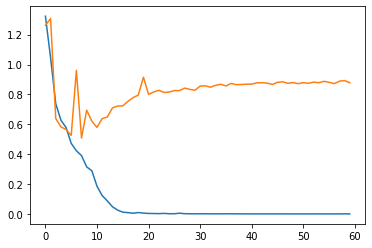

Original achieved best F1 score after  7  epochs.

Evaluation Results
_________________________________
Predicted 1071 / 1376 correctly
Mean Loss: 0.63 
Accuracy: 77.83%
Macro Averaged F1-score: 77.91%
_________________________________
Training loss - validation loss average difference:  0.6947760286692345


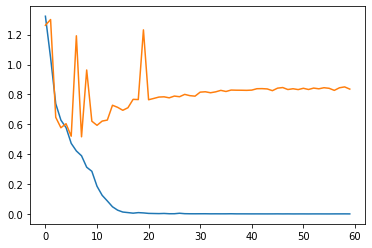

Weight Decay achieved best F1 score after  7  epochs.

Evaluation Results
_________________________________
Predicted 1054 / 1376 correctly
Mean Loss: 0.65 
Accuracy: 76.60%
Macro Averaged F1-score: 76.70%
_________________________________
Training loss - validation loss average difference:  0.48773340352437905


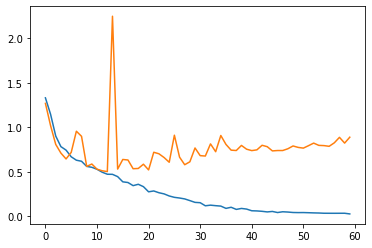

Dropout achieved best F1 score after  55  epochs.

Evaluation Results
_________________________________
Predicted 1064 / 1376 correctly
Mean Loss: 1.08 
Accuracy: 77.33%
Macro Averaged F1-score: 77.76%
_________________________________
Training loss - validation loss average difference:  0.5233730555017003


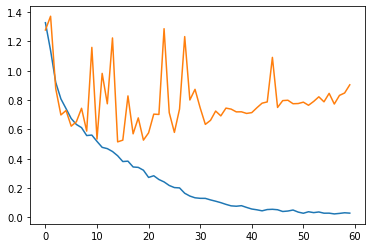

Both achieved best F1 score after  37  epochs.

Evaluation Results
_________________________________
Predicted 1052 / 1376 correctly
Mean Loss: 1.02 
Accuracy: 76.45%
Macro Averaged F1-score: 77.53%
_________________________________
          0               1               2               3               4
0                  Original    Weight Decay         Dropout            Both
1  Accuracy           77.83            76.6           77.33           76.45
2  F1-score           77.91            76.7           77.76           77.53
3      Time  0:04:58.315105  0:06:15.031324  0:07:54.840498  0:08:26.228667


In [62]:
# Hyperparameters
learning_rate = 8e-3
epochs= 60
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda'

Results = np.empty(shape=(4, 5), dtype=object)
Results[0,0] = ""
Results[1,0] = "Accuracy"
Results[2,0] = "F1-score"
Results[3,0] = "Time"

for i in range(4):

    # Seeding the libraries
    seedTorch()
    startTime = time.time()

    activationFunction = nn.SiLU

    if i==0:
        model = fourthConvolutionalNeuralNetwork(activationFunction).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
        Results[0,i+1] = "Original"
    elif i==1:
        model = fourthConvolutionalNeuralNetwork(activationFunction).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=1e-6)
        Results[0,i+1] = "Weight Decay"
    elif i==2:
        model = fifthConvolutionalNeuralNetwork(activationFunction).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
        Results[0,i+1] = "Dropout"
    else:
        model = fifthConvolutionalNeuralNetwork(activationFunction).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=1e-6)
        Results[0,i+1] = "Both"

    lossfunc = nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.78, verbose =False)

    # Model training
    bestepoch = optimalRegularization(device, model, epochs, train_Mel_dataloader, val_Mel_dataloader, optimizer, lossfunc, False, scheduler)

    print(Results[0,i+1],"achieved best F1 score after ", bestepoch, " epochs.")

    seedTorch()

    # Load the best model
    if i==0 or i==1:
        model = fourthConvolutionalNeuralNetwork(activationFunction).to(device)
    else:
        model = fifthConvolutionalNeuralNetwork(activationFunction).to(device)
    model.load_state_dict(torch.load('./bestCNNmodel.pt'))
    model = model.to(device)

    # Score on the test set
    trues, preds, meanloss, acura, f1 = evaluationFunction(test_Mel_dataloader, model, lossfunc, device, True)

    endTime = time.time()
    took = endTime - startTime

    Results[1,i+1] = float("{:.2f}".format(acura))
    Results[2,i+1] = float("{:.2f}".format(f1))
    Results[3,i+1] = str(datetime.timedelta(seconds=took))

with pd.option_context('expand_frame_repr', False):
    print(DataFrame(Results))

- From the learning curves we can see that the difference between the train loss and the validation loss decreases until one epoch, but then increases in all combinations. Also, without using Dropout, the model becomes optimal after 7 epochs in the first two trainings.

- Dropout can reduce the difference between the training and validation sets, as can weight decay, but they cannot automatically improve performance in predictions. This is evident from the performance on the test set, where both accuracy and F1-score remain almost the same with the introduction of weight decay or dropout, as well as their combination.

- Now, the deviation of the losses decreases with the use of weight decay and especially dropout, but this happens very early. This is logical because overfitting begins after one epoch, so the train loss is greatly reduced. Now, to examine the losses at an earlier stage, I will try with 30 epochs, increasing the learning rate to 8e-2 and the weight decay to 1e-4.

Training loss - validation loss average difference:  0.9578307030148772


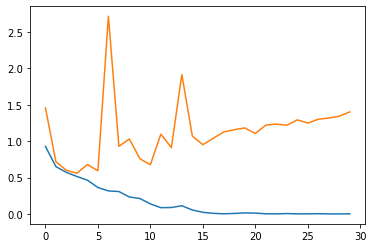

Original achieved best F1 score after  15  epochs.

Evaluation Results
_________________________________
Predicted 1061 / 1376 correctly
Mean Loss: 1.30 
Accuracy: 77.11%
Macro Averaged F1-score: 77.61%
_________________________________
Training loss - validation loss average difference:  1.0050754764393501


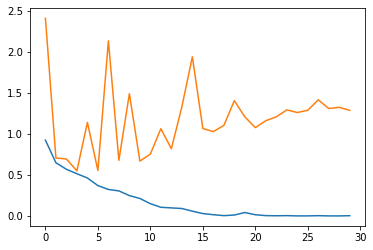

Weight Decay achieved best F1 score after  16  epochs.

Evaluation Results
_________________________________
Predicted 1063 / 1376 correctly
Mean Loss: 1.38 
Accuracy: 77.25%
Macro Averaged F1-score: 77.82%
_________________________________
Training loss - validation loss average difference:  0.9952474271319562


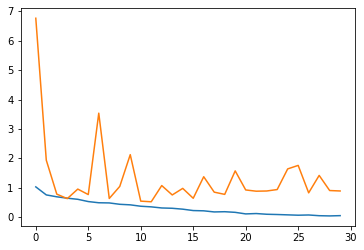

Dropout achieved best F1 score after  11  epochs.

Evaluation Results
_________________________________
Predicted 1101 / 1376 correctly
Mean Loss: 0.60 
Accuracy: 80.01%
Macro Averaged F1-score: 80.52%
_________________________________
Training loss - validation loss average difference:  0.5210441681168679


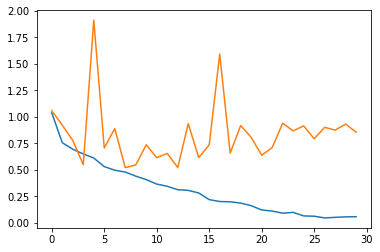

Both achieved best F1 score after  20  epochs.

Evaluation Results
_________________________________
Predicted 1091 / 1376 correctly
Mean Loss: 0.92 
Accuracy: 79.29%
Macro Averaged F1-score: 79.61%
_________________________________
          0               1               2               3               4
0                  Original    Weight Decay         Dropout            Both
1  Accuracy           77.11           77.25           80.01           79.29
2  F1-score           77.61           77.82           80.52           79.61
3      Time  0:02:28.310109  0:03:11.667759  0:03:57.777789  0:04:14.373063


In [63]:
# Hyperparameters
learning_rate = 8e-2
epochs= 60
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda'

Results = np.empty(shape=(4, 5), dtype=object)
Results[0,0] = ""
Results[1,0] = "Accuracy"
Results[2,0] = "F1-score"
Results[3,0] = "Time"

for i in range(4):

    # Seeding
    seedTorch()
    startTime = time.time()
    activationFunction = nn.SiLU

    if i==0:
        model = fourthConvolutionalNeuralNetwork(activationFunction).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
        Results[0,i+1] = "Original"
    elif i==1:
        model = fourthConvolutionalNeuralNetwork(activationFunction).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=1e-4)
        Results[0,i+1] = "Weight Decay"
    elif i==2:
        model = fifthConvolutionalNeuralNetwork(activationFunction).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
        Results[0,i+1] = "Dropout"
    else:
        model = fifthConvolutionalNeuralNetwork(activationFunction).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=1e-4)
        Results[0,i+1] = "Both"

    lossfunc = nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.78, verbose =False)

    # Model training
    bestepoch = optimalRegularization(device, model, epochs, train_Mel_dataloader, val_Mel_dataloader, optimizer, lossfunc, False, scheduler)

    print(Results[0,i+1],"achieved best F1 score after ", bestepoch, " epochs.")

    seedTorch()

    # Loading the model with the best performance
    if i==0 or i==1:
        model = fourthConvolutionalNeuralNetwork(activationFunction).to(device)
    else:
        model = fifthConvolutionalNeuralNetwork(activationFunction).to(device)
    model.load_state_dict(torch.load('./bestCNNmodel.pt'))
    model = model.to(device)

    # Evaluate on the test set
    trues, preds, meanloss, acura, f1 = evaluationFunction(test_Mel_dataloader, model, lossfunc, device, True)

    endTime = time.time()
    took = endTime - startTime

    Results[1,i+1] = float("{:.2f}".format(acura))
    Results[2,i+1] = float("{:.2f}".format(f1))
    Results[3,i+1] = str(datetime.timedelta(seconds=took))

with pd.option_context('expand_frame_repr', False):
    print(DataFrame(Results))

- Now it is even more apparent that using Dropout reduces the difference between validation loss and train loss to the greatest extent. Also, when combined with weight decay, they have the smallest difference, but weight decay alone cannot combat overfitting in this specific Neural Network.

- The performance achieved by the Neural Network on the test set is now reaching 80% and this happens after 11 epochs, so the model does not have enough time to memorize the details of the training set, which makes it even better at generalizing. As is more often the case, it is better to initially focus on the model's performance and then combat overfitting. This is where the value of this methodology is evident, as now with the use of Dropout and weight decay in the optimizer, the model can be better generalized and has a better performance on the test set.

### Step 7: Training efficiency

#### Batch size

- In this section, I will examine the batch size, which can affect the final performance of the model, as well as the training time.

In [71]:
# Hyperparameters
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 8e-2
lossfunc = nn.CrossEntropyLoss()
epochs = 60
activationFunction=nn.SiLU

Results = np.empty(shape=(5, 8), dtype=object)
Results[0,0] = "Batch Size"
Results[1,0] = "Accuracy"
Results[2,0] = "F1 Macro"
Results[3,0] = "Epochs"
Results[4,0] = "Time"

for i in range(7):
    batch_size=2**(i+1)
    print("Batch size: " , batch_size)
    print("__________________________________\n")
    Results[0,i+1] = batch_size

    seedTorch(33)
    trainB_dataloader = DataLoader(dataset=trainMelDataset, batch_size=batch_size, shuffle=True)
    valB_dataloader = DataLoader(dataset=valMelDataset, batch_size=batch_size, shuffle=True)
    testB_dataloader = DataLoader(dataset=testMelDataset, batch_size=batch_size, shuffle=False)
    
    startTime = time.time()
    
    model = fifthConvolutionalNeuralNetwork(activationFunction).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.78, verbose =False)

    # Model training
    bestEp = optimalModel(device, model, epochs, trainB_dataloader, valB_dataloader, optimizer, lossfunc, False, scheduler)
    
    print("Best f1 score after: ", bestEp, " epochs.")

    seedTorch(33)    
    model = fifthConvolutionalNeuralNetwork(activationFunction).to(device)
    model.load_state_dict(torch.load('./bestCNNmodel.pt'))
    model = model.to(device)

    # Evaluate on the test set
    trues, preds, meanloss, acura, f1 = evaluationFunction(testB_dataloader, model, lossfunc, device, display=True)

    endTime = time.time()
    took = endTime - startTime

    Results[1,i+1] = float("{:.2f}".format(acura))
    Results[2,i+1] = float("{:.2f}".format(f1))
    Results[3,i+1] = bestEp
    Results[4,i+1] = str(datetime.timedelta(seconds=took))
    print("__________________________________\n")

with pd.option_context('expand_frame_repr', False):
    print (DataFrame(Results))

Batch size:  2
__________________________________

Best f1 score after:  25  epochs.

Evaluation Results
_________________________________
Predicted 1032 / 1376 correctly
Mean Loss: 0.67 
Accuracy: 75.00%
Macro Averaged F1-score: 75.13%
_________________________________
__________________________________

Batch size:  4
__________________________________

Best f1 score after:  25  epochs.

Evaluation Results
_________________________________
Predicted 1048 / 1376 correctly
Mean Loss: 1.06 
Accuracy: 76.16%
Macro Averaged F1-score: 77.11%
_________________________________
__________________________________

Batch size:  8
__________________________________

Best f1 score after:  54  epochs.

Evaluation Results
_________________________________
Predicted 1063 / 1376 correctly
Mean Loss: 1.75 
Accuracy: 77.25%
Macro Averaged F1-score: 77.26%
_________________________________
__________________________________

Batch size:  16
__________________________________

Best f1 score after:  36  e

- After 60 epochs the accuracy and F1-Score are similar with every batch size. The training time is what significantly decreases as the batch size increases. This is important, if we want to have fast training in order to select hyperparameters and we see that we can achieve this simply by increasing the batch size.

|  Batch Size |              2  |             4  |             8  |            16  |            32     |         64   |          128|
| ----------- | ----------- |----------- |----------- | ----------- |----------- |----------- |----------- |
|    Accuracy |           75.0  |         76.16  |         77.25  |         76.24   |        79.43   |        76.31    |       77.98|
|    F1 Macro |          75.13  |         77.11  |         77.26  |         76.91    |       79.64  |         77.26    |       78.46|
|      Epochs |             25  |            25  |            54  |            36    |          52       |       10     |         54|
|        Time | 1:39:22.458099  | 0:57:06.209285 | 0:43:13.224736 |  0:17:00.627147 | 0:09:42.473330 |  0:04:52.275264 | 0:01:20.095876|

- A large batch size allows the model to be trained faster as it leverages the parallelism of computations with the GPU. But too large may lead to poor generalization of the model, so the ideal should be found for each network.

- It can also be observed that the snapshot with the best performance for each batch size changes, with 2 and 4 being relatively early at 25 epochs. This happens because smaller batch sizes allow the model to "learn" without needing to see all the data. In general, it is better, if there is no computational limitation, to initially test with a relatively small batch size that requires fewer epochs to train, and then to increase the batch size until the ideal is found.

#### Early stopping

- Up to this point, I saved the best snapshot of the model and then used it to evaluate the test set, but the model continued training until the final number of epochs. Here, I will try the early stopping technique where the training process will stop after a predetermined number of epochs where the model performance does not improve.

- To automate the process and try different values of patience, I create the earlyStop function. To give the model a chance to not "get stuck" when the loss does not decrease, I use the ReduceLROnPlateau scheduler.

In [102]:
# Early stopping function for training
def earlyStop(device, neuralclass, display, epochs, traindataloader, valdataloader, lr, opti, lossfunc, activationFunction, patience):

    seedTorch(33)
    model = neuralclass(activationFunction=activationFunction).to(device)
    stopepoch=0
    countStop=0
    bestMeanloss= sys.float_info.max
    optimizer = opti(model.parameters(), lr = lr , weight_decay=1e-6)
    scheduler=lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.4, patience=1, verbose=False)

    # For each epoch
    for epoch in range(epochs):

        # If the patience without improvement has been reached stop
        if countStop==patience:
            print("Early stopping on epoch: ", epoch)
            stopepoch=epoch
            break

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        meanLoss = trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display)
        _, _, meanlossval, accura, macrof1 = evaluationFunction(valdataloader, model, lossfunc, device, display)

        # If mean loss is better set it as best so far
        if bestMeanloss>meanlossval:
            countStop=0
            bestMeanloss=meanlossval
        else:
            countStop+=1
        
        scheduler.step(meanLoss)    

    return model, stopepoch

- As a stopping condition, I have the mean loss on the validation set to be smaller than the smallest up to that point. I also trialed with accuracy, F1-score, and the mean loss from the immediately previous epoch, but I didn't have good results as sometimes the loss oscillated. That is, it improved for one epoch and worsened in the next, so it wasn't a reliable condition since the model had essentially stopped improving.

- Below, I call the earlyStop function to train the model for different values of patience, and then when it stops, I evaluate on the test set. I use a batch size of 32, which as I saw before had good results and was fast, so I set it to 60 epochs to have representative results since with a larger patience it will require more epochs to terminate based on the condition.

In [103]:
# I use batch size 32 to train faster
trainC_dataloader = DataLoader(dataset=trainMelDataset, batch_size=32, shuffle=True)
valC_dataloader = DataLoader(dataset=valMelDataset, batch_size=32, shuffle=True)
testC_dataloader = DataLoader(dataset=testMelDataset, batch_size=32, shuffle=False)

# Hyperparameters
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.008
lossfunc = nn.CrossEntropyLoss()
epochs = 60
activationFunction=nn.SiLU

# Results matrix
Results = np.empty(shape=(5, 7), dtype=object)
Results[0,0] = "Patience"
Results[1,0] = "Accuracy"
Results[2,0] = "F1 Macro"
Results[3,0] = "Epochs"
Results[4,0] = "Time"

# Patience 3 to 13 with step 2
for patience in range(3, 14, 2):
    i=int((patience-1)/2-1)
    Results[0,i+1] = patience
    print("Testing with patience: ", patience)

    # Seeding
    seedTorch(33)
    startTime = time.time()
    model = fourthConvolutionalNeuralNetwork
    optimizer = torch.optim.SGD

    # Network training
    model, bestEp = earlyStop(device, model, False, epochs, trainC_dataloader, valC_dataloader, lr, optimizer, lossfunc, activationFunction, patience)

    # Evaluation
    trues, preds, meanloss, acura, f1 = evaluationFunction(testC_dataloader, model, lossfunc, device, display=True)

    # Save the results
    Results[1,i+1] = float("{:.2f}".format(acura))
    Results[2,i+1] = float("{:.2f}".format(f1))
    Results[3,i+1] = bestEp
    Results[4,i+1] = str(datetime.timedelta(seconds=time.time()-startTime))

with pd.option_context('expand_frame_repr', False):
    print (DataFrame(Results))


Testing with patience:  3
Early stopping on epoch:  12

Evaluation Results
_________________________________
Predicted 951 / 1376 correctly
Mean Loss: 0.82 
Accuracy: 69.11%
Macro Averaged F1-score: 68.92%
_________________________________
Testing with patience:  5
Early stopping on epoch:  18

Evaluation Results
_________________________________
Predicted 1048 / 1376 correctly
Mean Loss: 0.79 
Accuracy: 76.16%
Macro Averaged F1-score: 75.71%
_________________________________
Testing with patience:  7
Early stopping on epoch:  20

Evaluation Results
_________________________________
Predicted 659 / 1376 correctly
Mean Loss: 3.20 
Accuracy: 47.89%
Macro Averaged F1-score: 39.94%
_________________________________
Testing with patience:  9
Early stopping on epoch:  22

Evaluation Results
_________________________________
Predicted 1066 / 1376 correctly
Mean Loss: 0.87 
Accuracy: 77.47%
Macro Averaged F1-score: 77.64%
_________________________________
Testing with patience:  11
Early stopp

- Looking at the epoch that the training stops improving, after the 18th epoch increasing the patience by 2 increases the early stopping epoch as well. So, it is clear that after that epoch there is no improvement on the model.

|  Patience  |             3      |         5   |            7      |         9       |       11     |         13 |
| ----------- | ----------- |----------- |----------- | ----------- |----------- |----------- |
|  Accuracy |           69.11 |          76.16  |         47.89  |         77.47   |        78.42   |        77.91 |
|  F1 Macro |          68.92  |         75.71   |        39.94   |        77.64    |       78.71    |       78.26 |
|    Epochs |             12  |            18   |           20   |           22    |          24    |          26 |
|      Time | 0:00:39.434749 | 0:00:57.441462 | 0:01:03.106734 | 0:01:09.875694 | 0:01:15.907822 | 0:01:21.600688 |

- I note here that in the above results, I do not use the best snapshot as I did with optimalModel, as this would be the same for all after 5. But I evaluate on the test set with the model snapshot at the end so that we have an idea of the performance at the epoch where it stopped.

- The accuracy of the model is very good and close to 80%. Early stopping is a regularization technique to avoid overfitting without affecting the accuracy of the model and this is evident here. Also, early stopping allows for a significant reduction in time as it stops much earlier than the total number of epochs is reached. Of course, there is a difference in runtime, and a higher value of patience increases time, which is expected since a larger number of epochs are given to the model to prevent improvement.

- As for the choice of patience, a small number may lead the model to not converge to the global minimum, while a very large number will lead to overfitting. Therefore, for the use of early stopping, patience, like any other hyperparameter with a grid search or tuning framework, like Optuna.

## Classification on Youtube Music

### Step 1: Inference

- In this section I'm testing the Convolutional Neural Network on real world data, by using music clips from youtube. I initally define the `genreGuesser` function which makes predictions on the dataloader that is provided.

In [130]:
def genreGuesser(dataloader, model, lossfunc, device, songtitle):

    trues, y, meanloss, acura, f1 = evaluationFunction(dataloader, model, lossfunc, device, display=True)
    x = list(range(0, len(y)))
    with plt.style.context('dark_background'):
        plt.figure(figsize=(16, 10), dpi=100)
        ylabels = ['Blues', 'Classical', 'HipHop', 'Rock']
        plt.yticks(list(range(0, 4)), ylabels)
        plt.plot(x, y, "mo")
        plt.title(songtitle)
    plt.show()

    return y

- I then define the best version of the model so far by removing a layer from the linear stack of the model and reducing the dropout that was found during tuning to work better.

In [105]:
# Convolutional Neural Network for youtube videos
class sixthConvolutionalNeuralNetwork(nn.Module):
    
    def __init__(self, activationFunction):
        super(sixthConvolutionalNeuralNetwork, self).__init__()

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            activationFunction(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(1024, 256), 
            activationFunction(),
            nn.Dropout(0.15),
            nn.Linear(256, 32),
            activationFunction(),
            nn.Linear(32, 4),
        )

    def forward(self, x): 

        logits = self.conv_stack(x)        
        return logits

- Then training this Convolutional Neural Network and finding the best snapshot of the model. During the training process, I made a small change and used the validation set for training and the test set, which is no longer used at the end, for validation. With the smaller set, the ability to generalize would be better on real songs.

In [166]:
# Hyperparameters
learning_rate = 8e-2
epochs= 60
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda'

# Batch size 32 for faster training
trainloader = DataLoader(dataset=valMelDataset, batch_size=32, shuffle=True)
validloader = DataLoader(dataset=testMelDataset, batch_size=32, shuffle=True)

# Seeding
seedTorch(33)

# Network initialisation
activationFunction = nn.SiLU
model = sixthConvolutionalNeuralNetwork(activationFunction).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.78, verbose =False)

# Training the Network and finding the optimal model
bestepoch = optimalModel(device, model, epochs, trainloader, validloader, optimizer, lossfunc, False, scheduler)

### Step 2: Music to Spectogram

- Initially, the installation of youtube-dl is needed:

In [ ]:
# To install youtube-dl
!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl

- The following functions download the music from the youtube url provided and then converts them to Mel-Spectograms.

In [122]:
window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21

def downloadSong(url):

    ydl_opts = {
        'format': 'bestaudio/best',
        'quiet': True,
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
    }
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])


def load_wav(filename):
    """Read audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url, title, genre):
    regex = re.compile('(.*wav)')
    downloadSong(url)
    
    for root, dirs, files in os.walk("."):
        for file in files:
            if regex.match(file):
                print(file)
                melgrams = get_melgrams(file)
                np.save("melgrams/"+genre+"/"+title+".npy", melgrams)
                os.remove(file)

- From each genre I selected three quite representative songs and save the urls on dictionaries. Then using the `youtube_to_melgram` function I download, convert them and save them localy as numpy files.

In [165]:
bluesURLs = {   
    "BBKing-HowBlueCanYouGet":"https://www.youtube.com/watch?v=l45f28PzfCI",
    "RobertJohnson-Crossroad": "https://www.youtube.com/watch?v=Yd60nI4sa9A",
    "SonHouse-DeathLetter":"https://www.youtube.com/watch?v=NdgrQoZHnNY",
} 

classicURLs = {
    "Chopin-Nocturne9":"https://www.youtube.com/watch?v=9E6b3swbnWg",
    "Bach-BWV974":"https://www.youtube.com/watch?v=ZIJtvsf8uCc",
    "Mozart-Lacrimosa":"https://www.youtube.com/watch?v=k1-TrAvp_xs",
} 

hiphopURLs = {
    "WarrenG-Regulate":"https://www.youtube.com/watch?v=1plPyJdXKIY",
    "Nas-NYState":"https://www.youtube.com/watch?v=hI8A14Qcv68",
    "DaftPunk-GetLucky":"https://www.youtube.com/watch?v=Rgrt_8mXrK8",
}

rockURLs = {    
    "LedZeppelin-ImmigrantSong" : "https://www.youtube.com/watch?v=RlNhD0oS5pk",
    "Metallica-MasterofPuppers":"https://www.youtube.com/watch?v=9kxTQm1vCjg",
    "Nirvana-DrainYou":"https://www.youtube.com/watch?v=AJUpHxlJUNQ",
}

# Download the songs and convert to melgrams
for key in hiphopURLs:
    youtube_to_melgram(hiphopURLs[key], key, "hiphop")

for key in classicURLs:
    youtube_to_melgram(classicURLs[key], key, "classical")

for key in bluesURLs:
    youtube_to_melgram(bluesURLs[key], key, "blues")

for key in rockURLs:
    youtube_to_melgram(rockURLs[key], key, "rock")

### Step 3: Predictions

- Initially loading the best model.

In [175]:
# Load model
seedTorch(33)
model = sixthConvolutionalNeuralNetwork(activationFunction)
model.load_state_dict(torch.load('./bestCNNmodel.pt'))
model = model.to(device)
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if torch.cuda.is_available() else 'cpu'
lossfunc = nn.CrossEntropyLoss()

- Then for each of the music genres I make predictions for each song belonging to it, by printing a diagram where the vertical axis represents the music classes and the horizontal axis represents the timestamps, corresponding to seconds.

- Also, I pass an array of the "correct" labels, indicating the music genre considered for that particular song (e.g. 0 for blues), so that I can see from the accuracy of the evaluationFunction what percentage of the song will be assigned to the music genre that a human would classify it as.


Evaluation Results
_________________________________
Predicted 96 / 313 correctly
Mean Loss: 2.97 
Accuracy: 30.67%
Macro Averaged F1-score: 11.74%
_________________________________


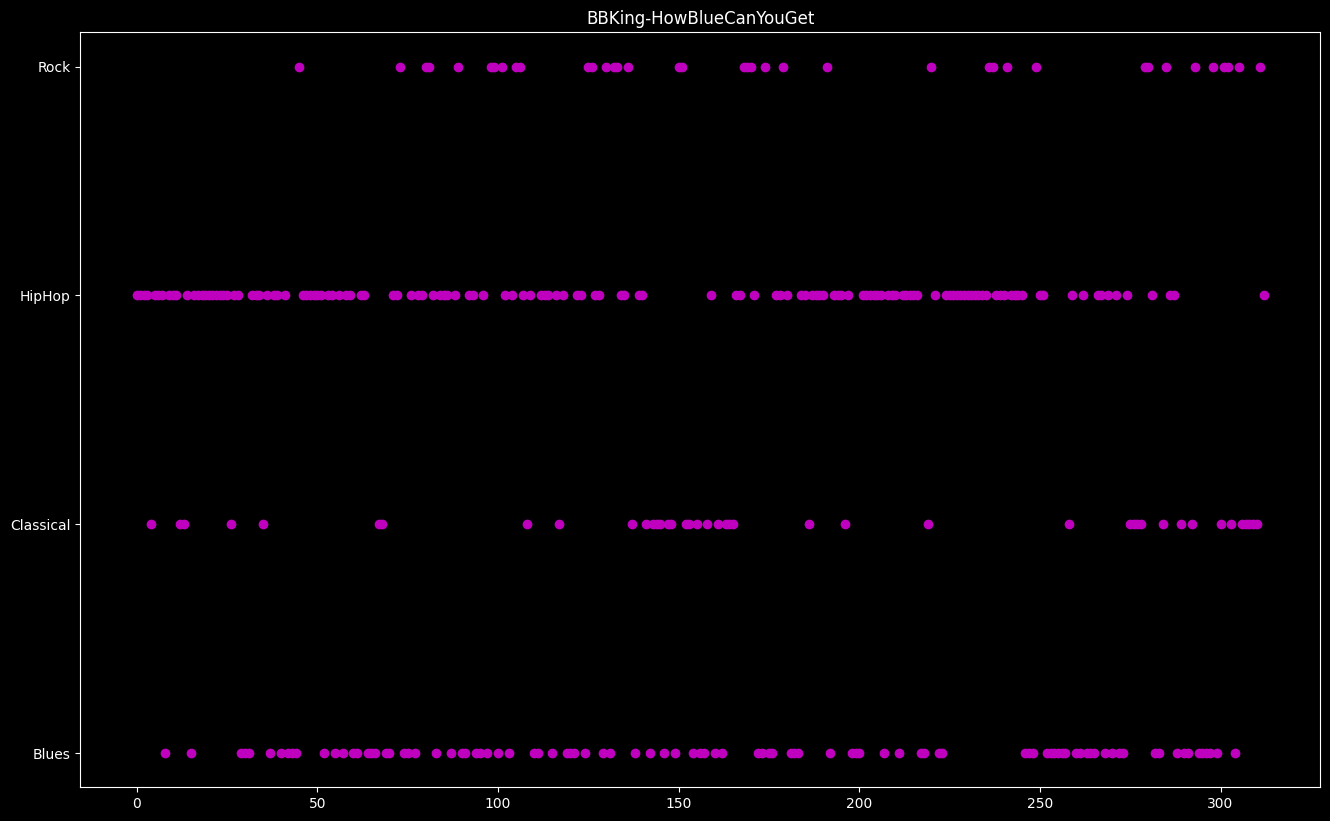


Evaluation Results
_________________________________
Predicted 113 / 169 correctly
Mean Loss: 2.94 
Accuracy: 66.86%
Macro Averaged F1-score: 26.71%
_________________________________


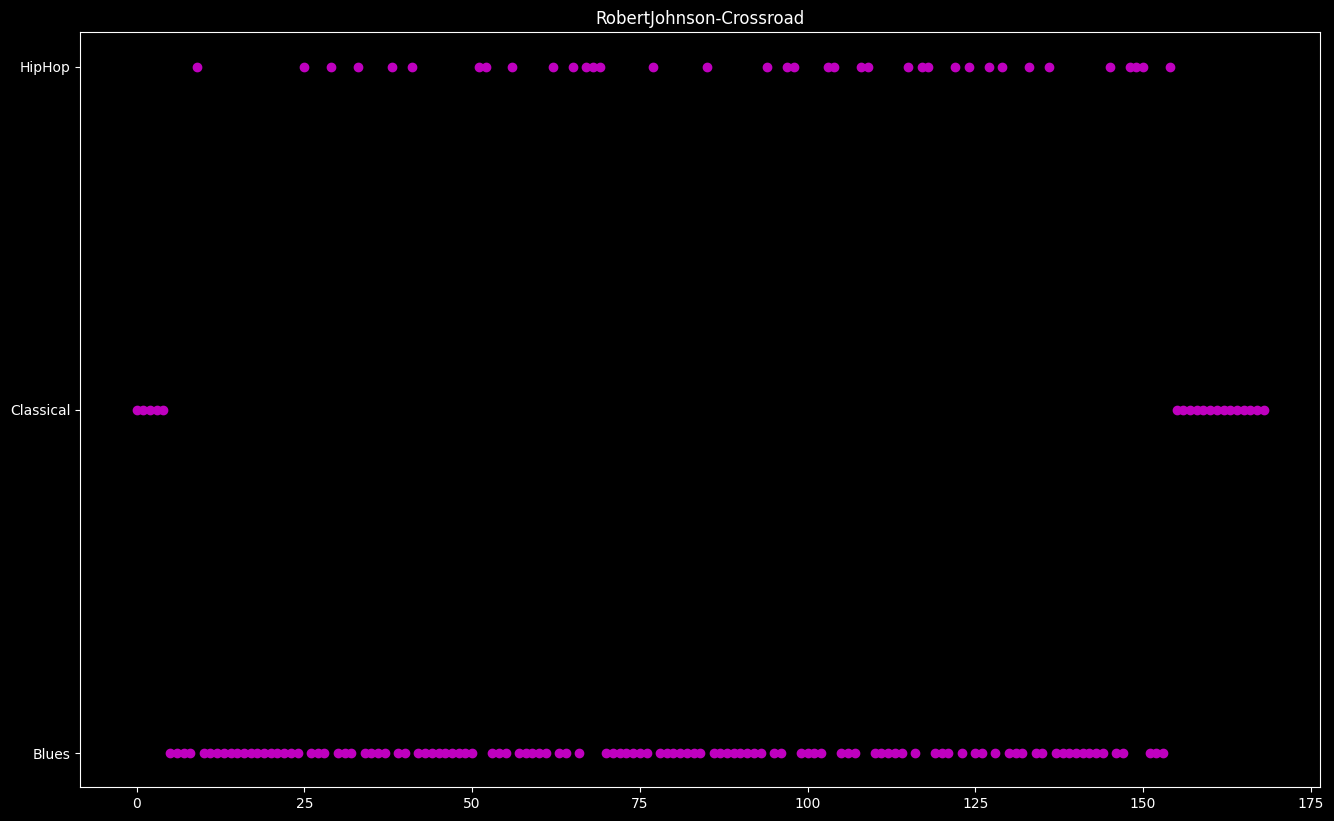


Evaluation Results
_________________________________
Predicted 146 / 208 correctly
Mean Loss: 0.89 
Accuracy: 70.19%
Macro Averaged F1-score: 20.62%
_________________________________


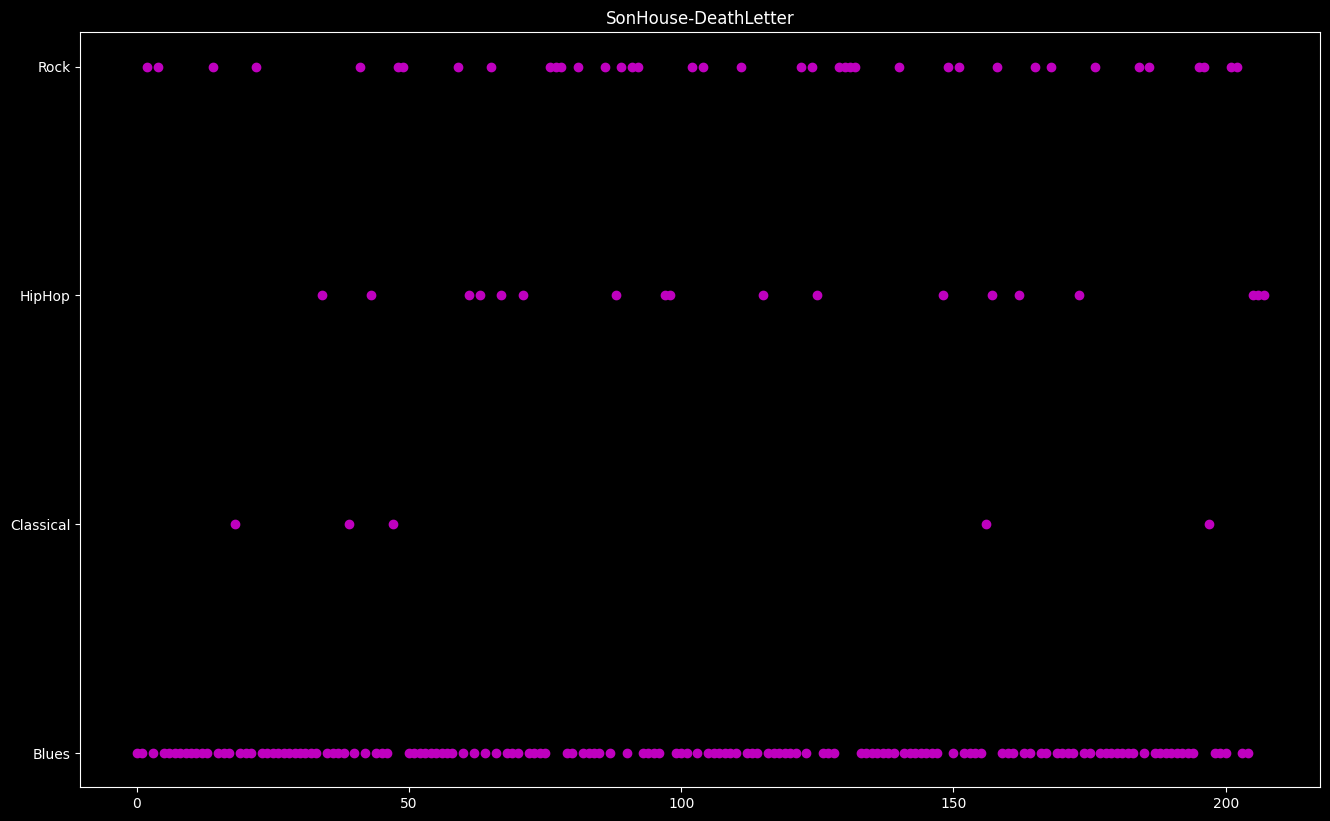

In [178]:
# Classify blues songs
for songtitle in bluesURLs:
    song = np.load("melgrams/blues/"+songtitle+".npy")
    songLabels = np.full((song.shape[0]), 0)
    songDataset = customMelDataset(song, songLabels)
    songDataloader = DataLoader(dataset=songDataset, batch_size=32, shuffle=False)
    genreGuesser(songDataloader, model, lossfunc, device, songtitle)

- The first song of BB King is of particular interest, as the seconds where the model predicts it as "Blues" are the ones where the guitar and high frequencies are more "prevalent", while in some other parts where the bass is more prominent, it is classified as "Hip Hop".

- The other two songs are classified with a high percentage as "Blues". This might also be because I used two traditional Blues songs by Robert Johnson and Son House that have a continuous repetitive melody with only guitar and vocals, without any other instruments or post-production additions, as in more modern music and recordings.

- Next, I test the model's predictions for classical music.


Evaluation Results
_________________________________
Predicted 191 / 270 correctly
Mean Loss: 1.13 
Accuracy: 70.74%
Macro Averaged F1-score: 20.72%
_________________________________


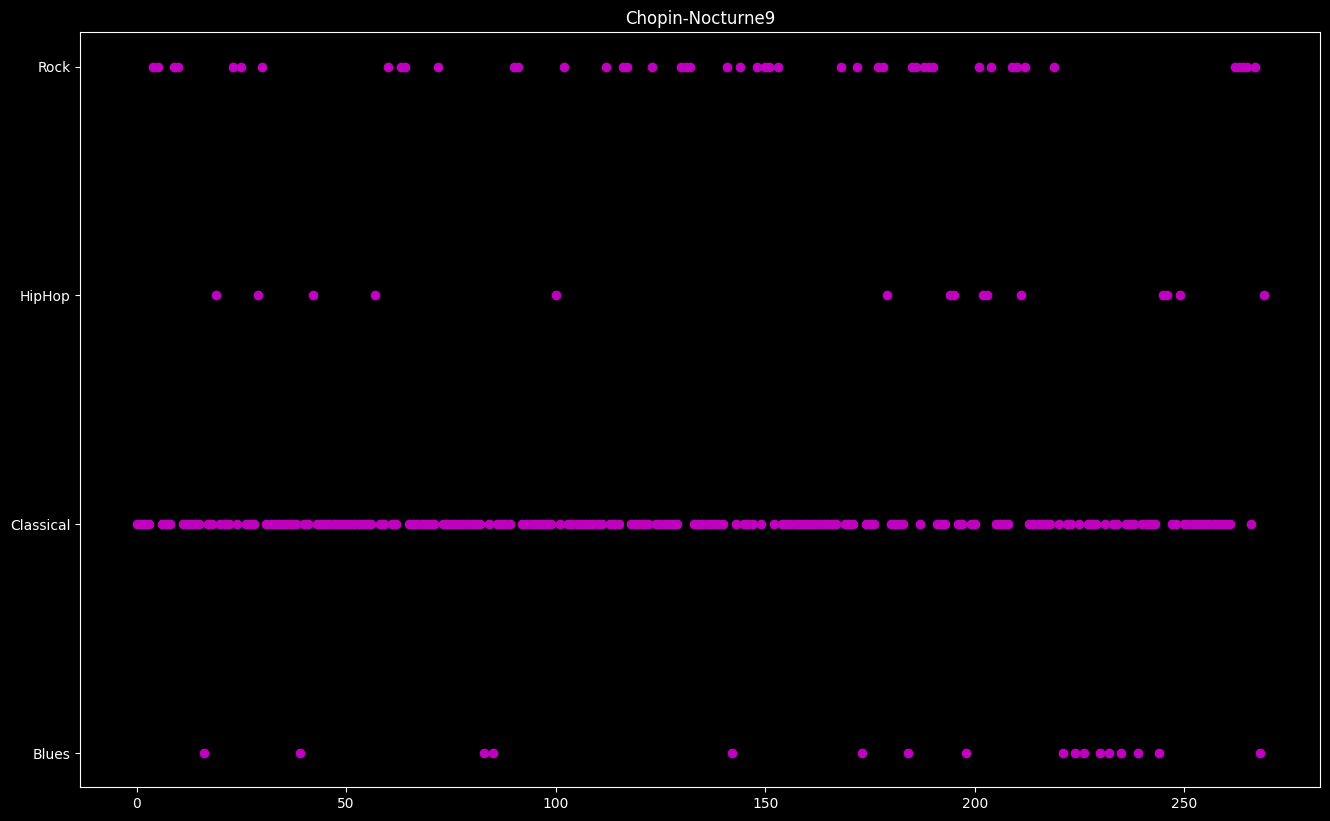


Evaluation Results
_________________________________
Predicted 147 / 215 correctly
Mean Loss: 1.16 
Accuracy: 68.37%
Macro Averaged F1-score: 20.30%
_________________________________


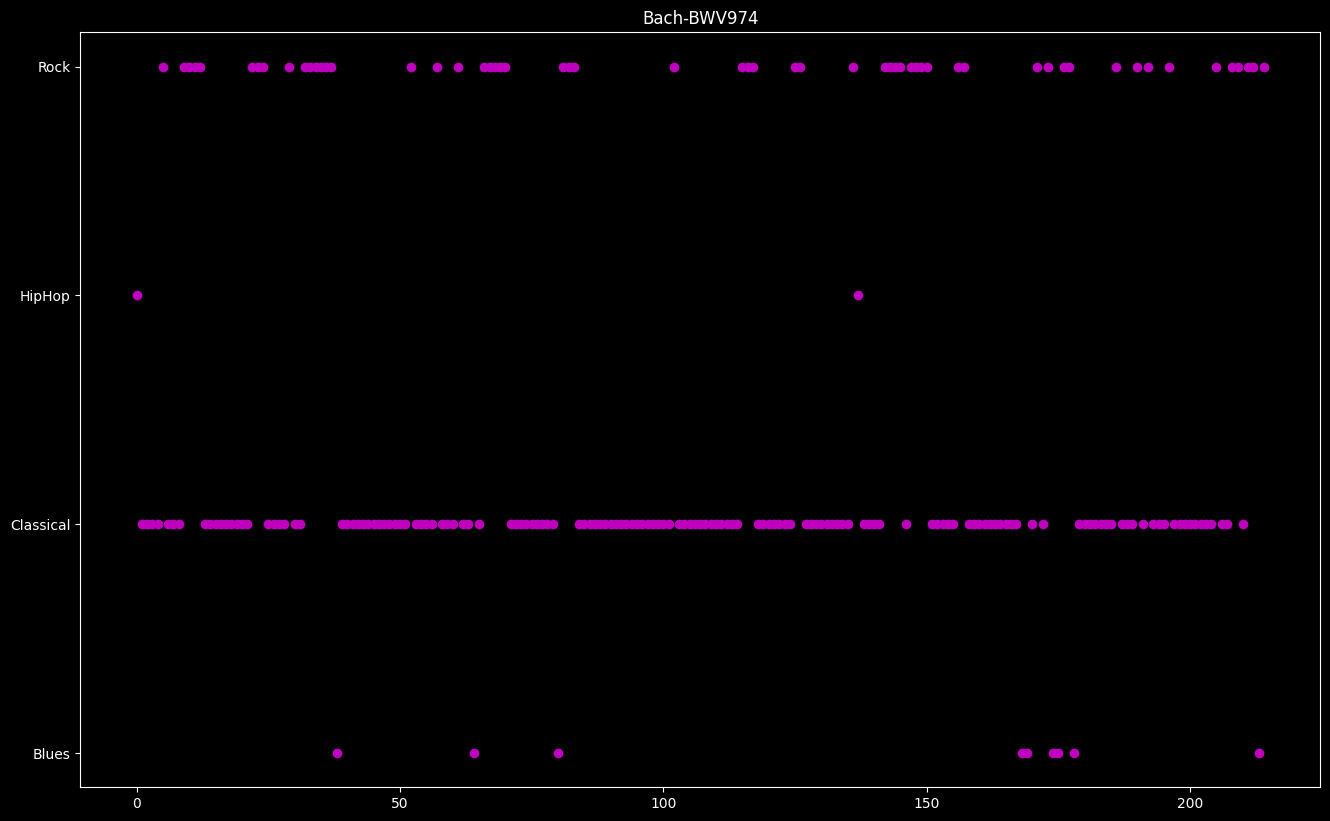


Evaluation Results
_________________________________
Predicted 166 / 201 correctly
Mean Loss: 0.49 
Accuracy: 82.59%
Macro Averaged F1-score: 22.62%
_________________________________


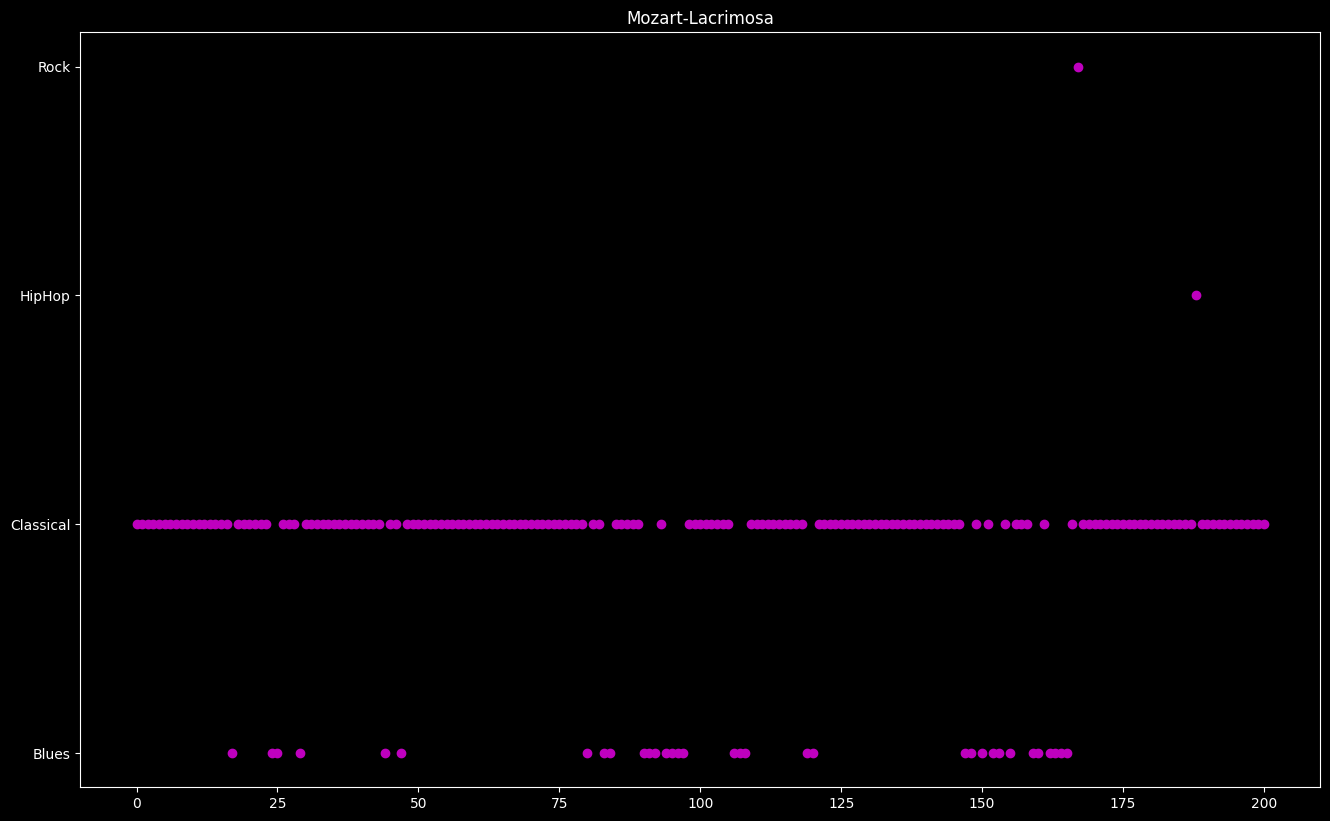

In [169]:
# Predictions on classical music
for songtitle in classicURLs:
    song = np.load("melgrams/classical/"+songtitle+".npy")
    songLabels = np.full((song.shape[0]), 1)
    songDataset = customMelDataset(song, songLabels)
    songDataloader = DataLoader(dataset=songDataset, batch_size=32, shuffle=False)
    genreGuesser(songDataloader, model, lossfunc, device, songtitle)

- For classical music, the model predicts with a higher degree of accuracy for all three songs that they belong to the genre of music that was expected. However, for the first two songs, it classifies certain seconds as a different genre, and upon listening to the songs, it is clear that there are points where the tone of the song changes.

- The Lacrimosa by Mozart is predicted to belong to classical music with 80% accuracy. Upon listening to the seconds classified as "Blues," it is those where the orchestra is not singing. Therefore, the reason for the classification with such a high percentage may be because the song is a requiem mass, with vocals present throughout almost the entire duration.

- Next, I will try the three songs I selected for the hip hop/pop genre.


Evaluation Results
_________________________________
Predicted 212 / 239 correctly
Mean Loss: 0.48 
Accuracy: 88.70%
Macro Averaged F1-score: 23.50%
_________________________________


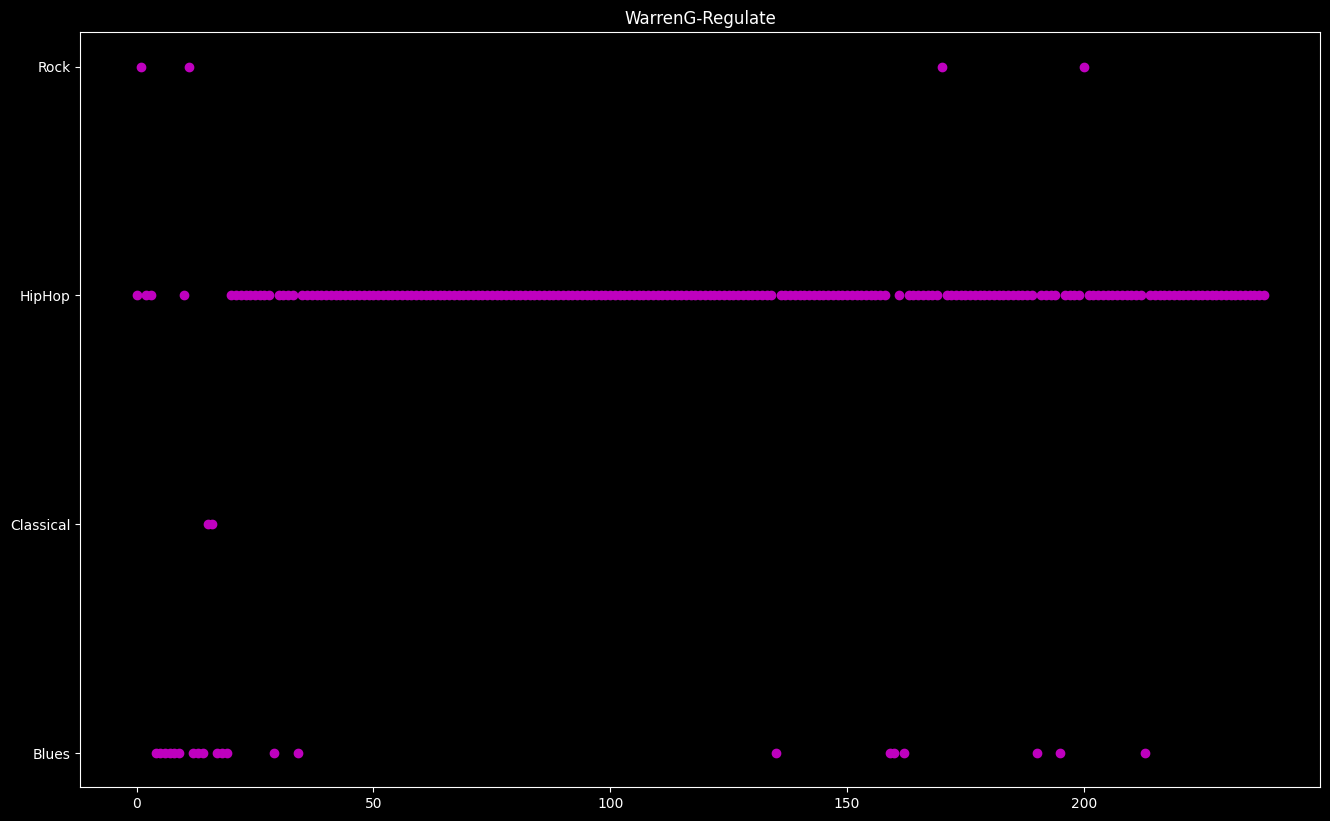


Evaluation Results
_________________________________
Predicted 262 / 296 correctly
Mean Loss: 0.58 
Accuracy: 88.51%
Macro Averaged F1-score: 23.48%
_________________________________


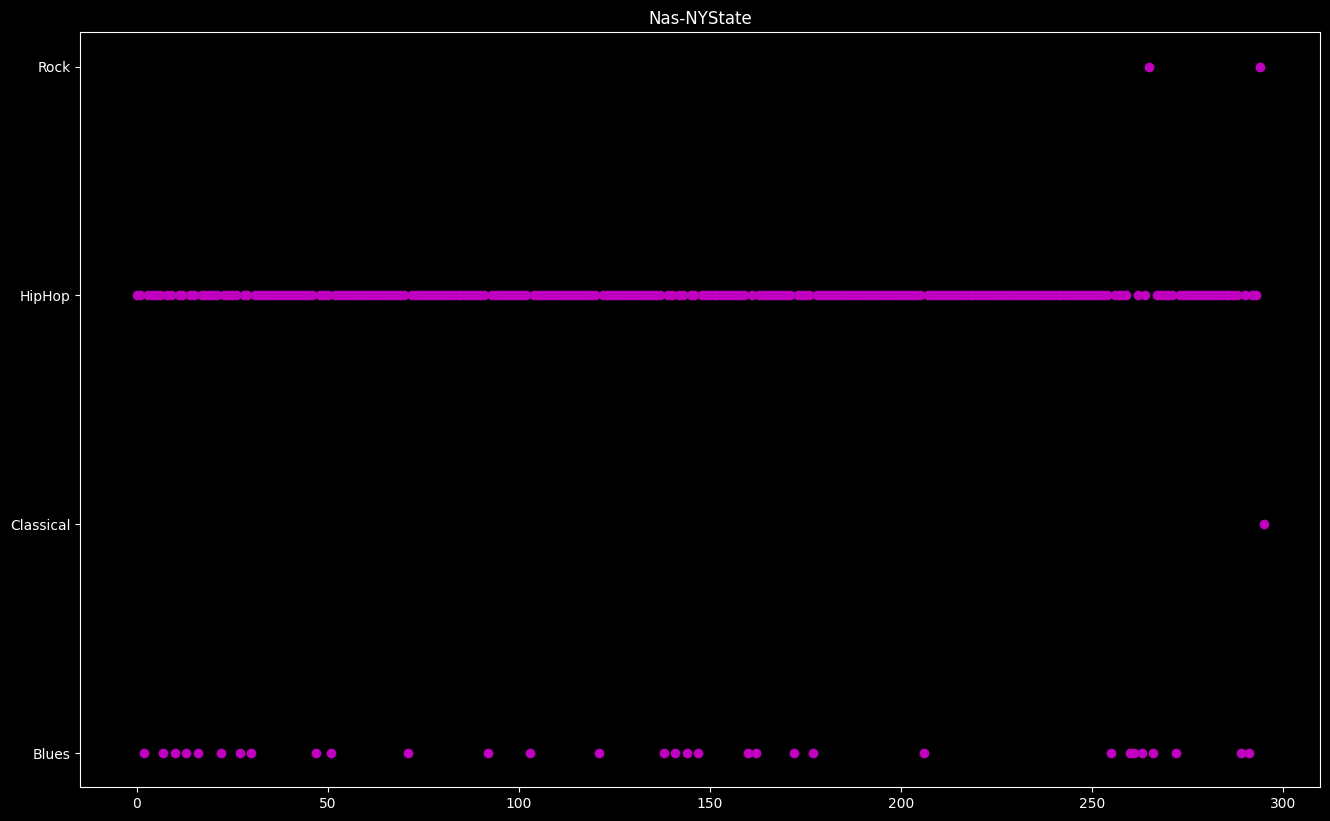


Evaluation Results
_________________________________
Predicted 199 / 249 correctly
Mean Loss: 0.84 
Accuracy: 79.92%
Macro Averaged F1-score: 22.21%
_________________________________


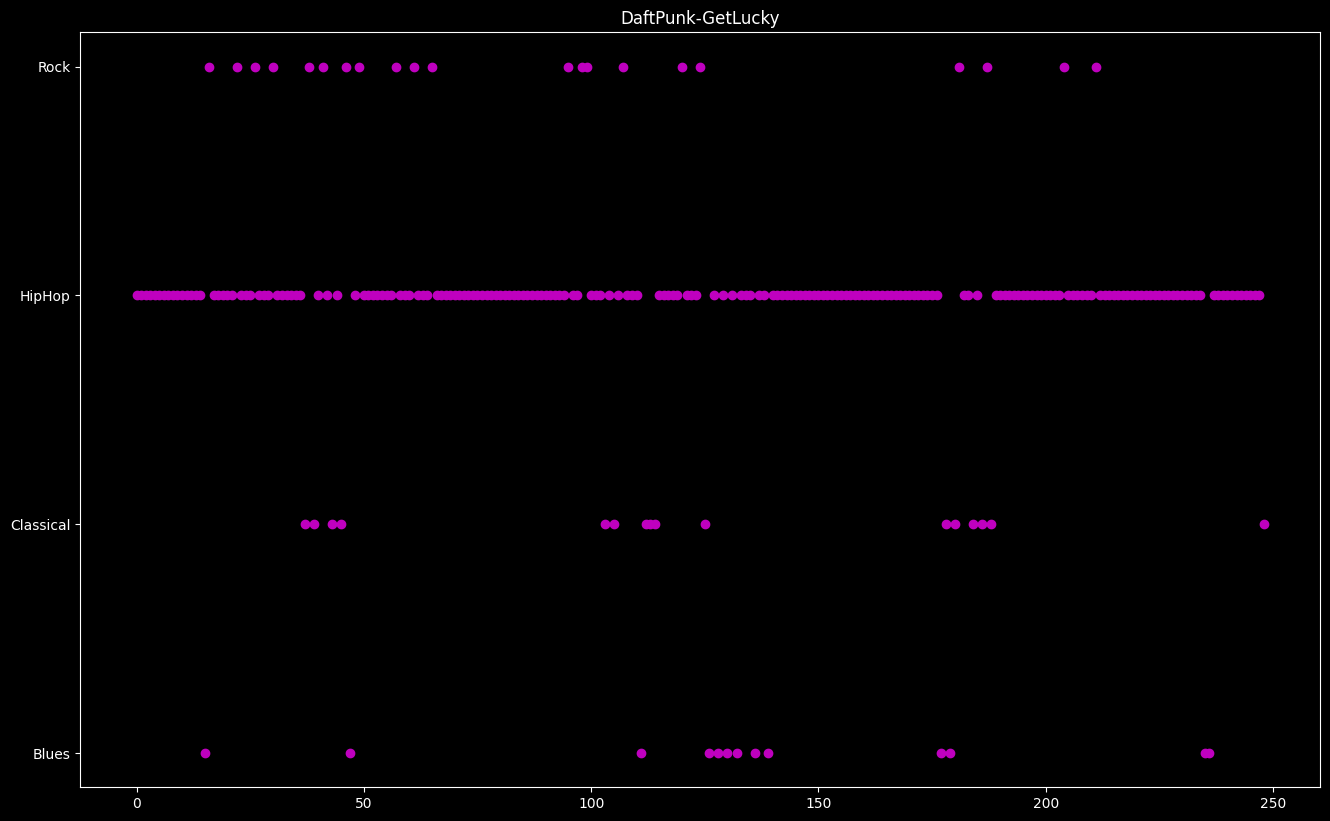

In [170]:
# Predictions of hip hop
for songtitle in hiphopURLs:
    song = np.load("melgrams/hiphop/"+songtitle+".npy")
    songLabels = np.full((song.shape[0]), 2)
    songDataset = customMelDataset(song, songLabels)
    songDataloader = DataLoader(dataset=songDataset, batch_size=32, shuffle=False)
    genreGuesser(songDataloader, model, lossfunc, device, songtitle)

- As for the hip hop/pop genre, I notice from the results that it has the best accuracy in classifying the entire piece in terms of the percentage of correct genre. The first two songs are almost 90% accurately classified as hip hop, which is expected since they have no fluctuations and have the same repetitive beat.

- For the third song, I chose "Get Lucky" by Daft Punk, which is not as "pure" in terms of genre. This is also evident in the fact that some seconds of the song are classified in other genres, although it is still classified with almost 80% accuracy in the hip hop/pop genre.

- Finally, I try on the three rock songs that I selected.


Evaluation Results
_________________________________
Predicted 112 / 248 correctly
Mean Loss: 1.72 
Accuracy: 45.16%
Macro Averaged F1-score: 15.56%
_________________________________


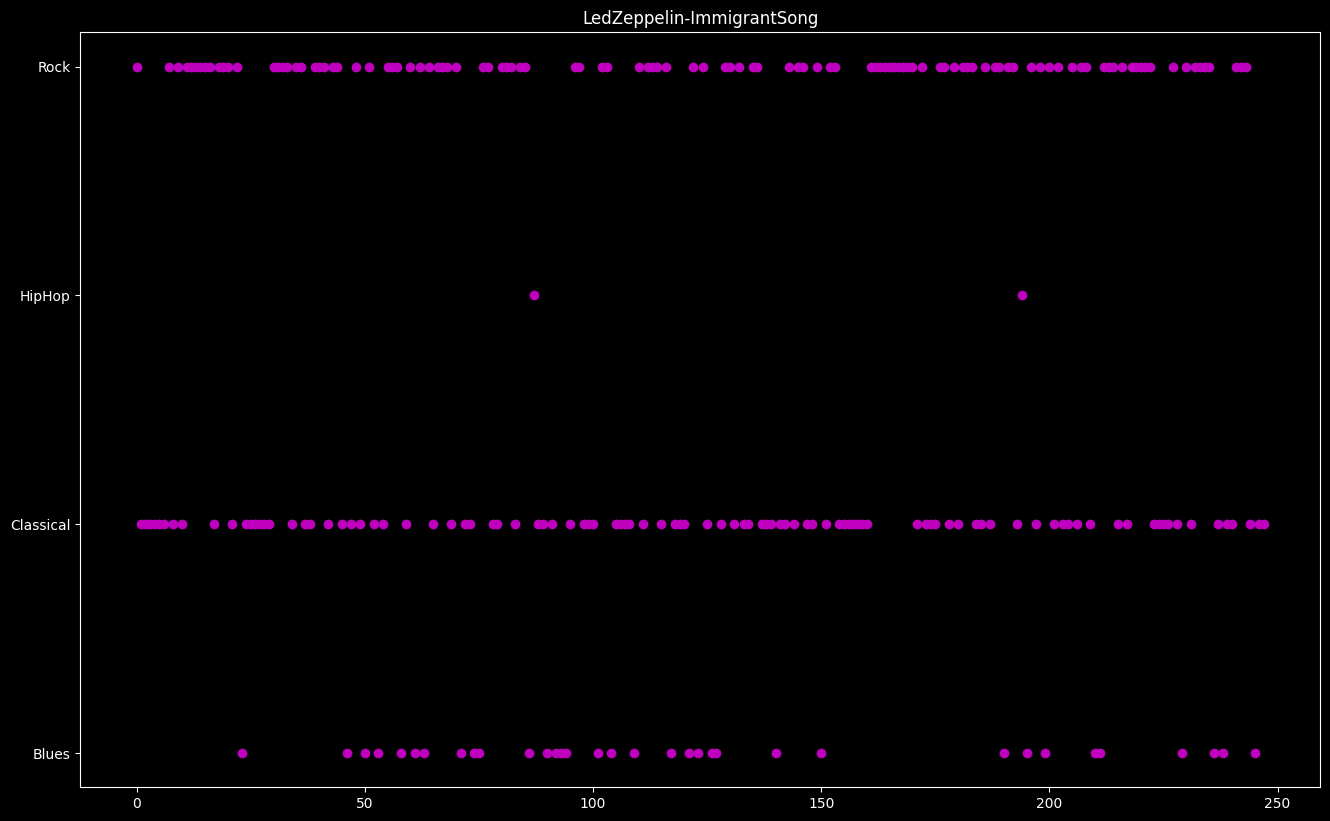


Evaluation Results
_________________________________
Predicted 131 / 239 correctly
Mean Loss: 1.59 
Accuracy: 54.81%
Macro Averaged F1-score: 17.70%
_________________________________


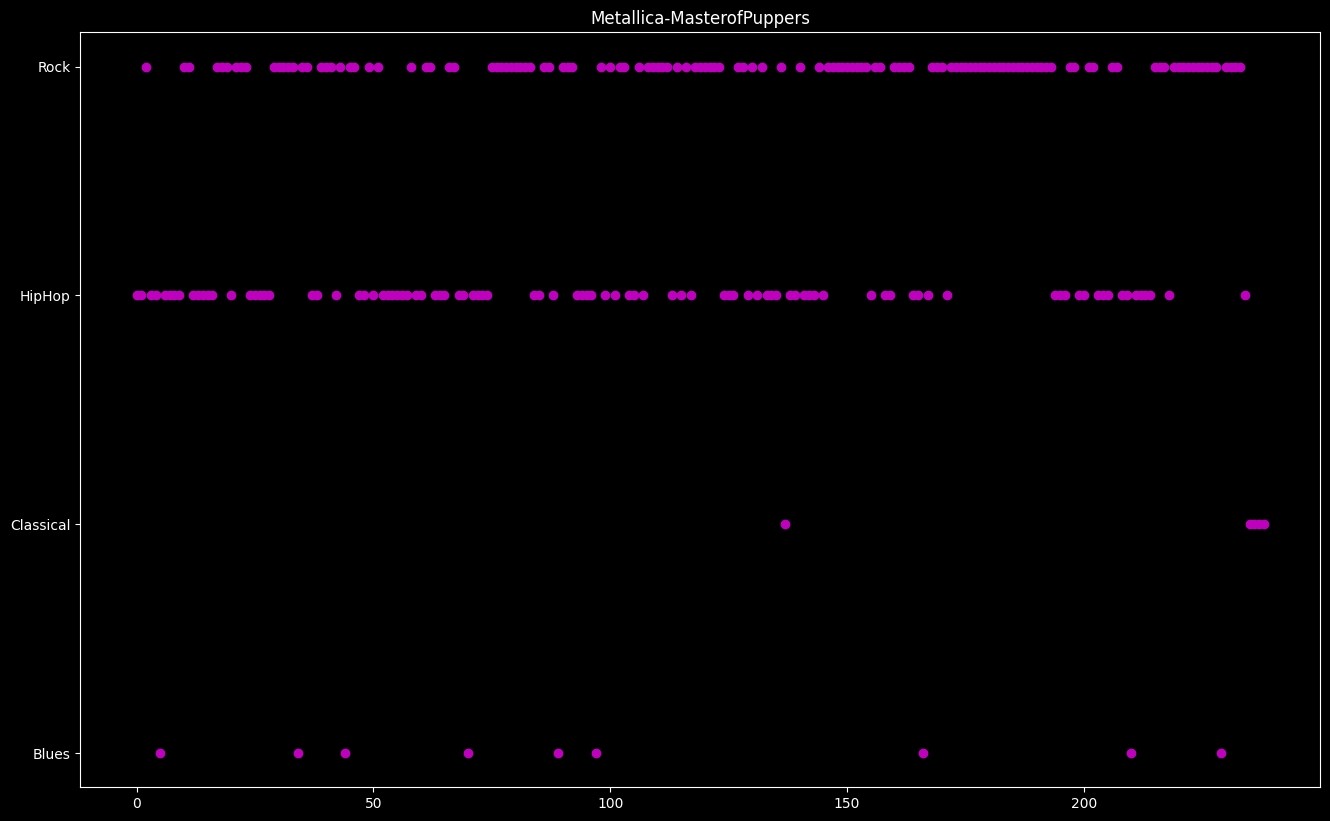


Evaluation Results
_________________________________
Predicted 106 / 224 correctly
Mean Loss: 1.82 
Accuracy: 47.32%
Macro Averaged F1-score: 16.06%
_________________________________


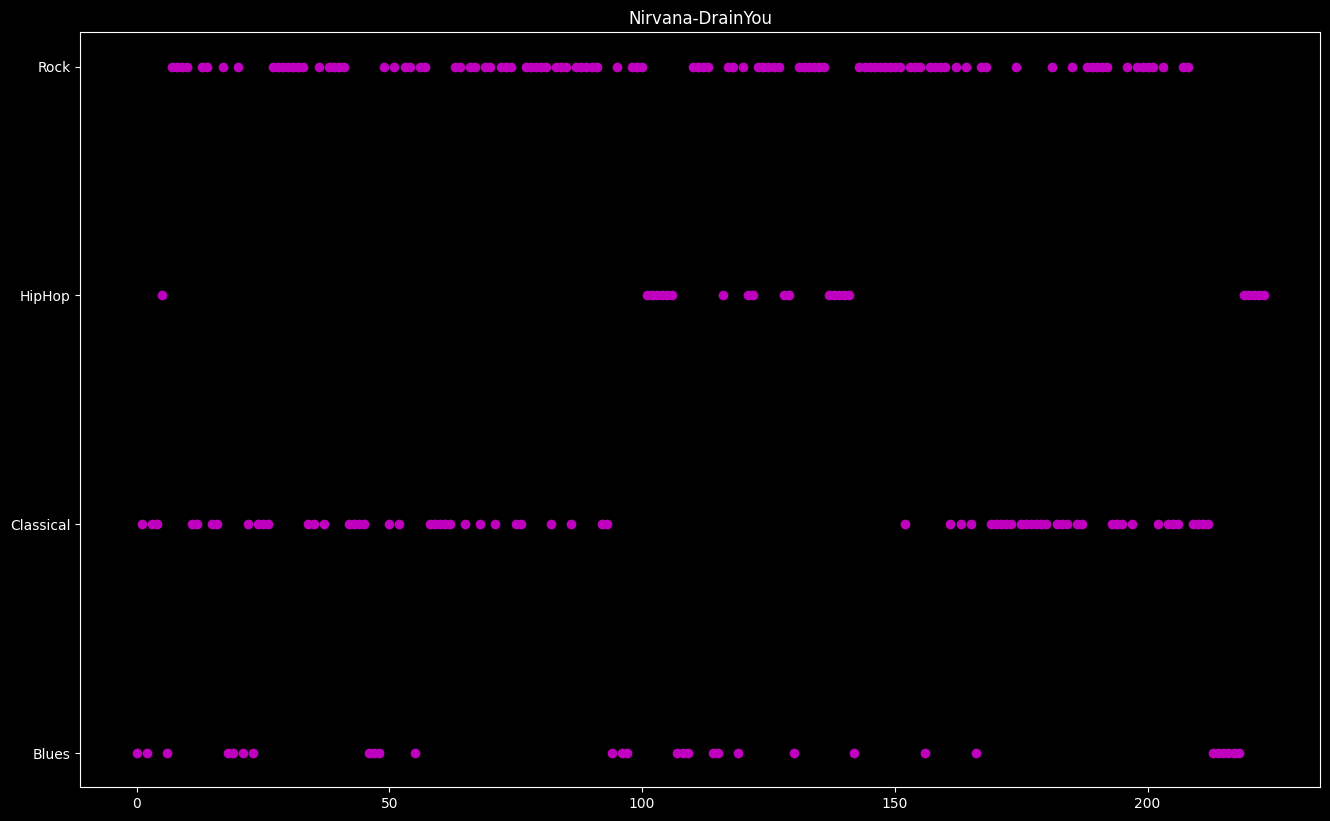

In [174]:
# Prediction on rock music
for songtitle in rockURLs:
    song = np.load("melgrams/rock/"+songtitle+".npy")
    songLabels = np.full((song.shape[0]), 3)
    songDataset = customMelDataset(song, songLabels)
    songDataloader = DataLoader(dataset=songDataset, batch_size=32, shuffle=False)
    genreGuesser(songDataloader, model, lossfunc, device, songtitle)

- The predictions of Rock songs don't make much sense if we look at them as a whole and judge them based on the accuracy and ranking percentage, which is below 50% for Rock. But listening to the song makes it more understandable why this happens.

- The song "Drain You," which starts only with guitar and vocals, is initially classified as Blues and Classical, while as soon as the drums start in the 8th second, it is immediately classified as Rock. The drums seem to be one of the elements that have some melodic feature that the model has memorized for this classification. This is also evident in the first few seconds of "Master of Puppets," which is classified as Rock.

- The classification of "Immigrant Song" as classical music happens in seconds of the song where the notes of Plant's tenor voice are quite high, while in the parts where the musical instruments are more prevalent, it is classified as Rock and in some parts as Blues.

- Overall, the model's predictions for all music genres are quite good, and even in the songs where the genre in which it should be classified is not predicted with great accuracy, it can be seen in the specific seconds why this happens.

- The Convolutional Neural Network manages to predict better the genre of older songs that do not have significant fluctuations in their melody and frequencies. Of course, there are some results that do not make sense in terms of the genre they were classified compared to the sound at that particular point, but I think this is due also to the similarities of the spectrum of frequencies that modern recordings of all genres of music have.